In [ ]:
from fractions import Fraction

class App:
    def __init__(self, id, duration, deadline):
        self.id = id
        self.duration = duration
        self.nominalRate = Fraction(1, duration)
        self.deadline = deadline
    def __repr__(self):
        return "app" + str(self.id)
    def __hash__(self):
        return self.id
    def __eq__(self, other):
        return self.id == other.id

class Scheduler:
    def addProgress(self, apps, time):
        raise Exception("Not Implemented")

class Spark:
    def __init__(self, scheduler, running={}, ended={}):
        self.running = dict(running)
        self.ended = dict(ended)
        self.scheduler = scheduler

    def schedule(self, app, time):
        if app in self.running or app in self.ended:
            return self

        all_apps = list(self.running.keys()) + list(self.ended.keys())
        for a in all_apps:
            if a.id == app.id - 1:
                break
        else:
            return self

        running = dict(self.running)
        running[app] = (time, Fraction())
        return Spark(self.scheduler, running, self.ended)

    def tick(self, time):
        if not self.running:
            return self

        running = dict(self.running)
        ended = dict(self.ended)

        self.scheduler.addProgress(running, time)

        for app, value in running.items():
            if value[1] >= 1:
                ended[app] = (value[0], time)
        for app in ended:
            if app in running:
                del running[app]

        return Spark(self.scheduler, running, ended)

    def __eq__(self, other):
        return self.running == other.running and self.ended == other.ended

    def __hash__(self):
        return self.__repr__().__hash__()

    def hasViolations(self, apps, steps):
        for app in apps:
            if app not in self.ended:
                return True
            elif app in self.ended and self.ended[app][1] - self.ended[app][0] > app.deadline:
                return True
        return False

    def computeViolations(self, apps, steps):
        for app in apps:
            if app in self.ended and self.ended[app][1] - self.ended[app][0] > app.deadline:
                return True
        return False

    def computeScenarioViolations(self, apps, steps):
        if self.computeViolations(apps, steps) or self.computeUnfisibility(apps, steps):
            return False
        for app in apps:
            if app not in self.ended and app in self.running and self.running[app][0] + app.duration <= steps:
                return True
        return False

    def computeUnfisibility(self, apps, steps):
        if self.computeViolations(apps, steps):
            return False
        for app in apps:
            if app not in self.ended and app not in self.running:
                return True
            if app not in self.ended and app in self.running and self.running[app][0] + app.duration > steps:
                return True
        return False

    def computeNonViolations(self, apps, steps):
        return not self.computeViolations(apps, steps) \
               and not self.computeScenarioViolations(apps, steps) \
               and not self.computeUnfisibility(apps, steps)

    def __repr__(self):
        return "r:%s, e:%s\n" % (self.running, self.ended)

    def error(self, apps):
        eA = eD = 0.0
        for app, value in self.ended.items():
            e = float(app.deadline - (self.ended[app][1] - self.ended[app][0])) / float(app.deadline)
            if e < 0:
                eD += abs(e)
            else:
                eA += e
        return eA / len(apps), eD / len(apps)

def nextStates(apps, state, time):
    if not apps:
        return {state}
    app = apps[0]
    if not state.running:
        return nextStates(apps[1:], state.schedule(app, time), time)
    else:
        return nextStates(apps[1:], state.schedule(app, time), time) | nextStates(apps[1:], state, time)

def simulate(initial, apps, steps):
    print(initial.scheduler.__class__.__name__, "-", steps)
    states = {initial}
    for t in range(steps + 1):
        newStates = set()
        for state in states:
            newStates |= nextStates(apps, state.tick(t), t)
        states = newStates

    eA = sum(map(lambda s: s.error(apps)[0], states)) / len(states)
    eD = sum(map(lambda s: s.error(apps)[1], states)) / len(states)
    print("eA = %.1f%%\neD = %.9f%%" % (eA * 100, eD * 100))

    violations = len([s for s in states if s.computeViolations(apps, steps)]) / len(states) * 100
    scenarioViolations = len([s for s in states if s.computeScenarioViolations(apps, steps)]) / len(states) * 100
    unfisibles = len([s for s in states if s.computeUnfisibility(apps, steps)]) / len(states) * 100
    nonViolations = len([s for s in states if s.computeNonViolations(apps, steps)]) / len(states) * 100
    print("Violations = %.1f%%\nScenario Violations = %.1f%%\nUnfisibles = %.1f%%\nNon Violations = %.1f%%" \
          % (violations, scenarioViolations, unfisibles, nonViolations))

# Define the schedulers
class FIFO(Scheduler):
    def addProgress(self, running, time):
        if not running:
            return
        first_app = min(running.keys(), key=lambda app: running[app][0])
        running[first_app] = (running[first_app][0], running[first_app][1] + first_app.nominalRate)

class Fair(Scheduler):
    def addProgress(self, running, time):
        if not running:
            return
        for app in running:
            running[app] = (running[app][0], running[app][1] + app.nominalRate / len(running))

class BipartiteGraph(Scheduler):
    def __init__(self):
        self.alternate = True

    def addProgress(self, running, time):
        if not running:
            return
        apps = sorted(running.keys(), key=lambda app: app.id)
        if self.alternate:
            selected_apps = apps[::2]  # Select every other app starting from index 0
        else:
            selected_apps = apps[1::2]  # Select every other app starting from index 1
        for app in selected_apps:
            running[app] = (running[app][0], running[app][1] + app.nominalRate)
        self.alternate = not self.alternate

class Adaptive(Scheduler):
    def addProgress(self, running, time):
        if not running:
            return
        for app in running:
            if running[app][0] + app.duration > app.deadline:
                running[app] = (running[app][0], running[app][1] + app.nominalRate * 2)  # Double progress rate if close to deadline
            else:
                running[app] = (running[app][0], running[app][1] + app.nominalRate)

# Initialize apps
scale = 1
apps = [App(1, 60 // scale, 300 // scale), App(2, 86 // scale, 300 // scale), App(3, 77 // scale, 120 // scale)]
steps = 720 // scale

# Simulate each scheduler and print results
schedulers = [FIFO(), Fair(), BipartiteGraph(), Adaptive()]
for scheduler in schedulers:
    init = Spark(scheduler, {apps[0]: (1, 0)}, {})
    simulate(init, apps, steps)
    print("\n" + "="*40 + "\n")


FIFO - 720
eA = 49.3%
eD = 6.708035289%
Violations = 62.2%
Scenario Violations = 0.0%
Unfisibles = 0.0%
Non Violations = 37.8%


Fair - 720
eA = 39.3%
eD = 6.570139882%
Violations = 62.3%
Scenario Violations = 0.0%
Unfisibles = 0.0%
Non Violations = 37.7%


BipartiteGraph - 720
eA = 34.6%
eD = 9.427828385%
Violations = 99.9%
Scenario Violations = 0.0%
Unfisibles = 0.0%
Non Violations = 0.1%


Adaptive - 720
eA = 71.2%
eD = 0.000000000%
Violations = 0.0%
Scenario Violations = 0.0%
Unfisibles = 0.0%
Non Violations = 100.0%




In [ ]:
from fractions import Fraction

class App:
    def __init__(self, id, duration, deadline, penalty):
        self.id = id
        self.duration = duration
        self.nominalRate = Fraction(1, duration)
        self.deadline = deadline
        self.penalty = penalty  # SLA penalty for missing deadline
    def __repr__(self):
        return "app" + str(self.id)
    def __hash__(self):
        return self.id
    def __eq__(self, other):
        return self.id == other.id

class Scheduler:
    def addProgress(self, apps, time):
        raise Exception("Not Implemented")

class Spark:
    def __init__(self, scheduler, running={}, ended={}):
        self.running = dict(running)
        self.ended = dict(ended)
        self.scheduler = scheduler

    def schedule(self, app, time):
        if app in self.running or app in self.ended:
            return self

        all_apps = list(self.running.keys()) + list(self.ended.keys())
        for a in all_apps:
            if a.id == app.id - 1:
                break
        else:
            return self

        running = dict(self.running)
        running[app] = (time, Fraction())
        return Spark(self.scheduler, running, self.ended)

    def tick(self, time):
        if not self.running:
            return self

        running = dict(self.running)
        ended = dict(self.ended)

        self.scheduler.addProgress(running, time)

        for app, value in running.items():
            if value[1] >= 1:
                ended[app] = (value[0], time)
        for app in ended:
            if app in running:
                del running[app]

        return Spark(self.scheduler, running, ended)

    def __eq__(self, other):
        return self.running == other.running and self.ended == other.ended

    def __hash__(self):
        return self.__repr__().__hash__()

    def hasViolations(self, apps, steps):
        for app in apps:
            if app not in self.ended:
                return True
            elif app in self.ended and self.ended[app][1] - self.ended[app][0] > app.deadline:
                return True
        return False

    def computeViolations(self, apps, steps):
        for app in apps:
            if app in self.ended and self.ended[app][1] - self.ended[app][0] > app.deadline:
                return True
        return False

    def computeScenarioViolations(self, apps, steps):
        if self.computeViolations(apps, steps) or self.computeUnfisibility(apps, steps):
            return False
        for app in apps:
            if app not in self.ended and app in self.running and self.running[app][0] + app.duration <= steps:
                return True
        return False

    def computeUnfisibility(self, apps, steps):
        if self.computeViolations(apps, steps):
            return False
        for app in apps:
            if app not in self.ended and app not in self.running:
                return True
            if app not in self.ended and app in self.running and self.running[app][0] + app.duration > steps:
                return True
        return False

    def computeNonViolations(self, apps, steps):
        return not self.computeViolations(apps, steps) \
               and not self.computeScenarioViolations(apps, steps) \
               and not self.computeUnfisibility(apps, steps)

    def __repr__(self):
        return "r:%s, e:%s\n" % (self.running, self.ended)

    def error(self, apps):
        eA = eD = 0.0
        for app, value in self.ended.items():
            e = float(app.deadline - (self.ended[app][1] - self.ended[app][0])) / float(app.deadline)
            if e < 0:
                eD += abs(e)
            else:
                eA += e
        return eA / len(apps), eD / len(apps)

def nextStates(apps, state, time):
    if not apps:
        return {state}
    app = apps[0]
    if not state.running:
        return nextStates(apps[1:], state.schedule(app, time), time)
    else:
        return nextStates(apps[1:], state.schedule(app, time), time) | nextStates(apps[1:], state, time)

def simulate(initial, apps, steps):
    print(initial.scheduler.__class__.__name__, "-", steps)
    states = {initial}
    for t in range(steps + 1):
        newStates = set()
        for state in states:
            newStates |= nextStates(apps, state.tick(t), t)
        states = newStates

    eA = sum(map(lambda s: s.error(apps)[0], states)) / len(states)
    eD = sum(map(lambda s: s.error(apps)[1], states)) / len(states)
    print("eA = %.1f%%\neD = %.9f%%" % (eA * 100, eD * 100))

    violations = len([s for s in states if s.computeViolations(apps, steps)]) / len(states) * 100
    scenarioViolations = len([s for s in states if s.computeScenarioViolations(apps, steps)]) / len(states) * 100
    unfisibles = len([s for s in states if s.computeUnfisibility(apps, steps)]) / len(states) * 100
    nonViolations = len([s for s in states if s.computeNonViolations(apps, steps)]) / len(states) * 100
    print("Violations = %.1f%%\nScenario Violations = %.1f%%\nUnfisibles = %.1f%%\nNon Violations = %.1f%%" \
          % (violations, scenarioViolations, unfisibles, nonViolations))

# Define the schedulers

class SLA(Scheduler):
    def addProgress(self, running, time):
        if not running:
            return
        # Sort apps by remaining time to deadline
        apps = sorted(running.keys(), key=lambda app: app.deadline - (time - running[app][0]))
        for app in apps:
            running[app] = (running[app][0], running[app][1] + app.nominalRate)
            if running[app][1] >= 1:
                break

# Initialize apps
scale = 1
apps = [App(1, 60 // scale, 300 // scale, 10), App(2, 86 // scale, 300 // scale, 20), App(3, 77 // scale, 120 // scale, 15)]
steps = 720 // scale

# Simulate each scheduler and print results
schedulers = [ SLA()]
for scheduler in schedulers:
    init = Spark(scheduler, {apps[0]: (1, 0)}, {})
    simulate(init, apps, steps)
    print("\n" + "="*40 + "\n")


SLA - 720
eA = 62.5%
eD = 0.000000000%
Violations = 0.0%
Scenario Violations = 0.0%
Unfisibles = 0.0%
Non Violations = 100.0%




In [ ]:
def fcfs_scheduler(tasks):
    time = 0
    schedule = []
    for task in tasks:
        schedule.append((task['task_id'], time, time + task['duration']))
        time += task['duration']
    return schedule


In [ ]:
from fractions import Fraction

class App:
    def __init__(self, id, duration, deadline, priority=0):
        self.id = id
        self.duration = duration
        self.nominalRate = Fraction(1, duration)
        self.deadline = deadline
        self.priority = priority

    def __repr__(self):
        return "app" + str(self.id)

    def __hash__(self):
        return self.id

    def __eq__(self, other):
        return self.id == other.id

class Scheduler:
    def addProgress(self, running, time):
        raise Exception("Not Implemented")

class Spark:
    def __init__(self, scheduler, running={}, ended={}):
        self.running = dict(running)
        self.ended = dict(ended)
        self.scheduler = scheduler

    def schedule(self, app, time):
        if app in self.running:
            return self
        elif app in self.ended:
            return self

        all_apps = list(self.running.keys()) + list(self.ended.keys())
        for a in all_apps:
            if a.id == app.id - 1:
                break
        else:
            return self

        running = dict(self.running)
        running[app] = (time, Fraction())
        return Spark(self.scheduler, running, self.ended)

    def tick(self, time):
        if not self.running:
            return self

        running = dict(self.running)
        ended = dict(self.ended)

        self.scheduler.addProgress(running, time)

        for app, value in running.items():
            if value[1] >= 1:
                ended[app] = (value[0], time)
        for app in ended:
            if app in running:
                del running[app]

        return Spark(self.scheduler, running, ended)

    def __eq__(self, other):
        if not isinstance(other, Spark):
            return False
        return self.running == other.running and self.ended == other.ended

    def __hash__(self):
        return hash((frozenset(self.running.items()), frozenset(self.ended.items())))

    def hasViolations(self, apps, steps):
        for app in apps:
            if app not in self.ended:
                return True
            elif app in self.ended and self.ended[app][1] - self.ended[app][0] > app.deadline:
                return True
        return False

    def computeViolations(self, apps, steps):
        for app in apps:
            if app in self.ended and self.ended[app][1] - self.ended[app][0] > app.deadline:
                return True
        return False

    def computeScenarioViolations(self, apps, steps):
        if self.computeViolations(apps, steps) or self.computeUnfeasibility(apps, steps):
            return False
        for app in apps:
            if app not in self.ended and app in self.running and self.running[app][0] + app.duration <= steps:
                return True
        return False

    def computeUnfeasibility(self, apps, steps):
        if self.computeViolations(apps, steps):
            return False
        for app in apps:
            if app not in self.ended and app not in self.running:
                return True
            if app not in self.ended and app in self.running and self.running[app][0] + app.duration > steps:
                return True
        return False

    def computeNonViolations(self, apps, steps):
        return not self.computeViolations(apps, steps) and not self.computeScenarioViolations(apps, steps) and not self.computeUnfeasibility(apps, steps)

    def __repr__(self):
        return "r:%s, e:%s\n" % (self.running, self.ended)

    def error(self, apps):
        eA = eD = 0.0
        for app, value in self.ended.items():
            e = float(app.deadline - (self.ended[app][1] - self.ended[app][0])) / float(app.deadline)
            if e < 0:
                eD += abs(e)
            else:
                eA += e
        return eA / len(apps), eD / len(apps)

def nextStates(apps, state, time):
    if not apps:
        return {state}
    app = apps[0]
    if not state.running:
        return nextStates(apps[1:], state.schedule(app, time), time)
    else:
        return nextStates(apps[1:], state.schedule(app, time), time) | nextStates(apps[1:], state, time)

def simulate(initial, apps, steps):
    print(initial.scheduler.__class__.__name__, "-", steps)
    states = {initial}
    for t in range(0, steps + 1, 1):
        newStates = set()
        for state in states:
            newStates |= nextStates(apps, state.tick(t), t)
        states = newStates

    eA = sum(map(lambda s: s.error(apps)[0], states)) / len(states)
    eD = sum(map(lambda s: s.error(apps)[1], states)) / len(states)
    print("eA = %.1f%%\neD = %.9f%%" % (eA * 100, eD * 100))

    violations = len([s for s in states if s.computeViolations(apps, steps)]) / len(states) * 100
    scenarioViolations = len([s for s in states if s.computeScenarioViolations(apps, steps)]) / len(states) * 100
    unfeasibles = len([s for s in states if s.computeUnfeasibility(apps, steps)]) / len(states) * 100
    nonViolations = len([s for s in states if s.computeNonViolations(apps, steps)]) / len(states) * 100
    print("Violations = %.1f%%\nScenario Violations = %.1f%%\nUnfeasibles = %.1f%%\nNon Violations = %.1f%%" \
          % (violations, scenarioViolations, unfeasibles, nonViolations))

# Define the SJF and Priority-based schedulers
class SJF(Scheduler):
    def addProgress(self, running, time):
        if not running:
            return
        shortest_app = min(running.keys(), key=lambda app: app.duration)
        running[shortest_app] = (running[shortest_app][0], running[shortest_app][1] + shortest_app.nominalRate)

class Priority(Scheduler):
    def addProgress(self, running, time):
        if not running:
            return
        highest_priority_app = min(running.keys(), key=lambda app: app.priority)
        running[highest_priority_app] = (running[highest_priority_app][0], running[highest_priority_app][1] + highest_priority_app.nominalRate)

# Initialize apps
scale = 1
apps = [App(1, 60 // scale, 300 // scale, priority=2), App(2, 86 // scale, 300 // scale, priority=1), App(3, 77 // scale, 120 // scale, priority=3)]
steps = 720 // scale

# Simulate each scheduler and print results
schedulers = [ SJF(), Priority()]
for scheduler in schedulers:
    init = Spark(scheduler, {apps[0]: (1, 0)}, {})
    simulate(init, apps, steps)
    print("\n" + "="*40 + "\n")


SJF - 720
eA = 49.2%
eD = 0.032427277%
Violations = 1.9%
Scenario Violations = 0.0%
Unfeasibles = 0.0%
Non Violations = 98.1%


Priority - 720
eA = 43.5%
eD = 6.710379908%
Violations = 62.2%
Scenario Violations = 0.0%
Unfeasibles = 0.0%
Non Violations = 37.8%




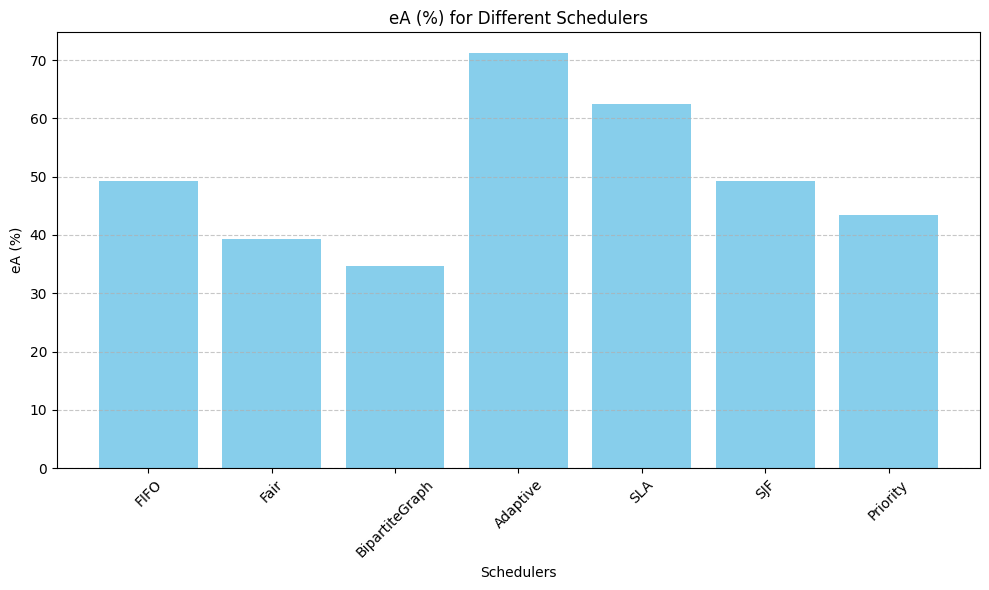

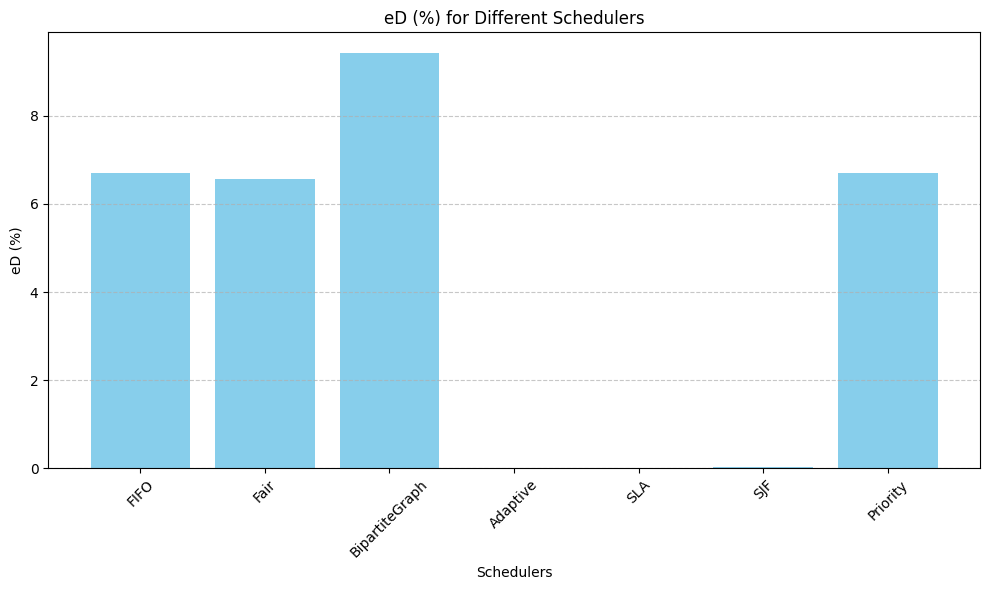

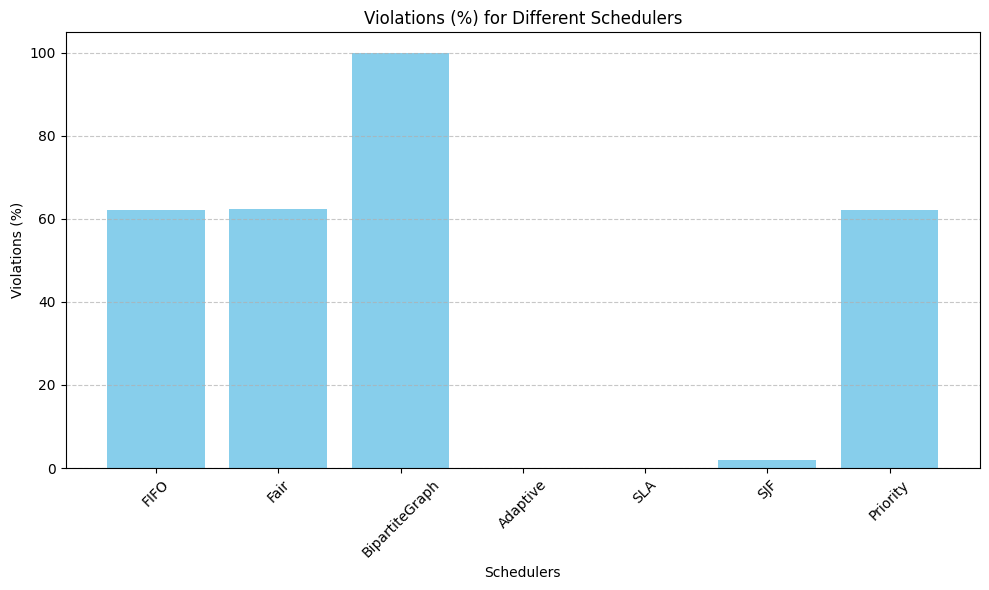

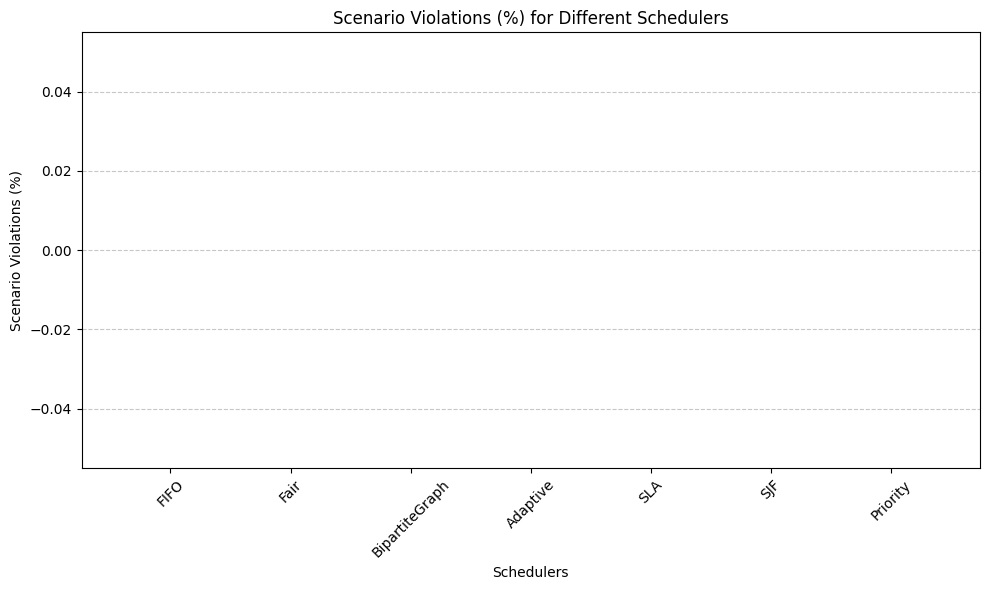

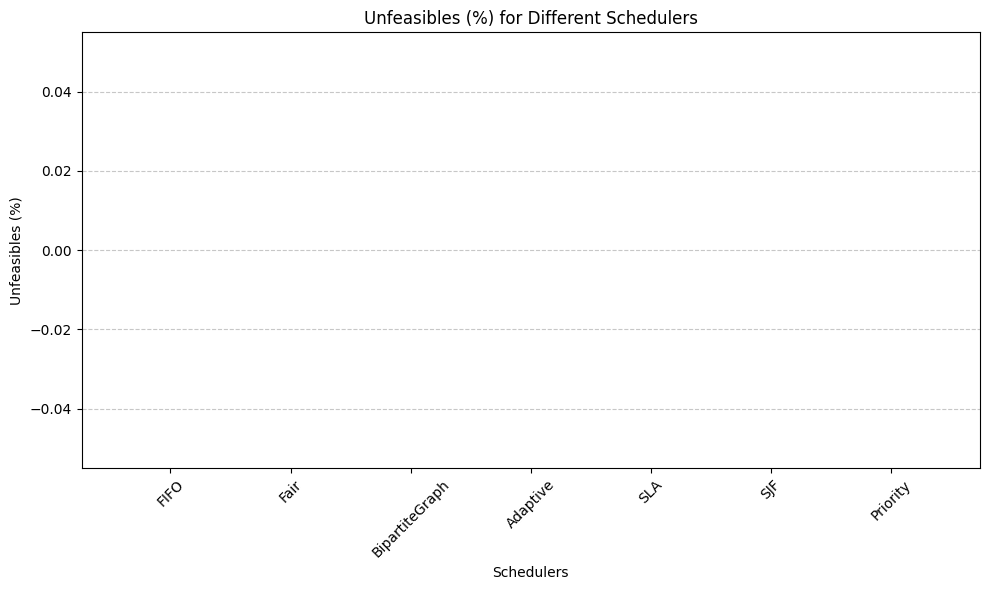

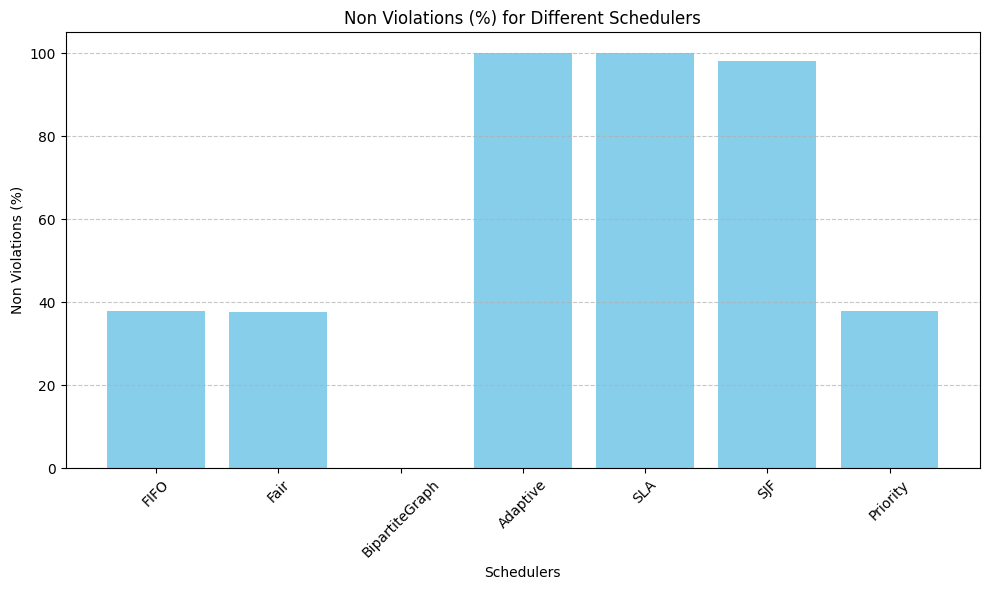

In [ ]:
import matplotlib.pyplot as plt

# Data
schedulers = ['FIFO', 'Fair', 'BipartiteGraph', 'Adaptive', 'SLA', 'SJF', 'Priority']
eA = [49.3, 39.3, 34.6, 71.2, 62.5, 49.2, 43.5]
eD = [6.708035289, 6.570139882, 9.427828385, 0.0, 0.0, 0.032427277, 6.710379908]
violations = [62.2, 62.3, 99.9, 0.0, 0.0, 1.9, 62.2]
scenario_violations = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
unfeasibles = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
non_violations = [37.8, 37.7, 0.1, 100.0, 100.0, 98.1, 37.8]

# Function to create and show bar plots
def create_bar_plot(parameter_name, values):
    plt.figure(figsize=(10, 6))
    plt.bar(schedulers, values, color='skyblue')
    plt.xlabel('Schedulers')
    plt.ylabel(parameter_name)
    plt.title(f'{parameter_name} for Different Schedulers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Create bar plots for each parameter
create_bar_plot('eA (%)', eA)
create_bar_plot('eD (%)', eD)
create_bar_plot('Violations (%)', violations)
create_bar_plot('Scenario Violations (%)', scenario_violations)
create_bar_plot('Unfeasibles (%)', unfeasibles)
create_bar_plot('Non Violations (%)', non_violations)


In [ ]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Generate synthetic data for cost efficiency in Spark job scheduling
def generate_synthetic_data(num_rows):
    data = []

    for i in range(1, num_rows+1):
        job_id = i
        task_id = 1
        start_time = datetime(2024, 6, 13, 8, 0, 0) + timedelta(minutes=random.randint(0, 1440))
        end_time = start_time + timedelta(minutes=random.randint(10, 30))
        input_size = random.randint(100000, 5000000)  # Bytes
        output_size = int(input_size * random.uniform(0.1, 0.5))  # Output size is a fraction of input size
        execution_time = random.randint(5000, 30000)  # Milliseconds
        cost = random.uniform(5, 20)  # Random cost between $5 to $20

        data.append([job_id, task_id, start_time, end_time, input_size, output_size, execution_time, cost])

        # Generate additional task for some jobs
        if random.random() < 0.5:
            task_id += 1
            start_time = end_time
            end_time = start_time + timedelta(minutes=random.randint(10, 30))
            input_size = random.randint(100000, 5000000)  # Bytes
            output_size = int(input_size * random.uniform(0.1, 0.5))  # Output size is a fraction of input size
            execution_time = random.randint(5000, 30000)  # Milliseconds
            cost = random.uniform(5, 20)  # Random cost between $5 to $20

            data.append([job_id, task_id, start_time, end_time, input_size, output_size, execution_time, cost])

    df = pd.DataFrame(data, columns=["Job_ID", "Task_ID", "Start_Time", "End_Time", "Input_Size(Bytes)", "Output_Size(Bytes)", "Execution_Time(ms)", "Cost($)"])
    return df

# Generate synthetic data with 100 rows
synthetic_data = generate_synthetic_data(100)

# Save the generated data as a CSV file
synthetic_data.to_csv("synthetic_data.csv", index=False)

# Display the first few rows of the generated data
print(synthetic_data.head())


   Job_ID  Task_ID          Start_Time            End_Time  Input_Size(Bytes)  \
0       1        1 2024-06-13 11:42:00 2024-06-13 12:00:00            3298592   
1       1        2 2024-06-13 12:00:00 2024-06-13 12:21:00            3561616   
2       2        1 2024-06-13 14:58:00 2024-06-13 15:27:00             577740   
3       2        2 2024-06-13 15:27:00 2024-06-13 15:40:00            2033783   
4       3        1 2024-06-13 09:11:00 2024-06-13 09:21:00             232166   

   Output_Size(Bytes)  Execution_Time(ms)    Cost($)  
0              631211               13131  14.449042  
1              723302               19218   8.556475  
2              129059                5707  19.591794  
3              643783               29521  15.270246  
4              107401               29928  12.759041  


<ipython-input-24-39f5949c2ef9>:48: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


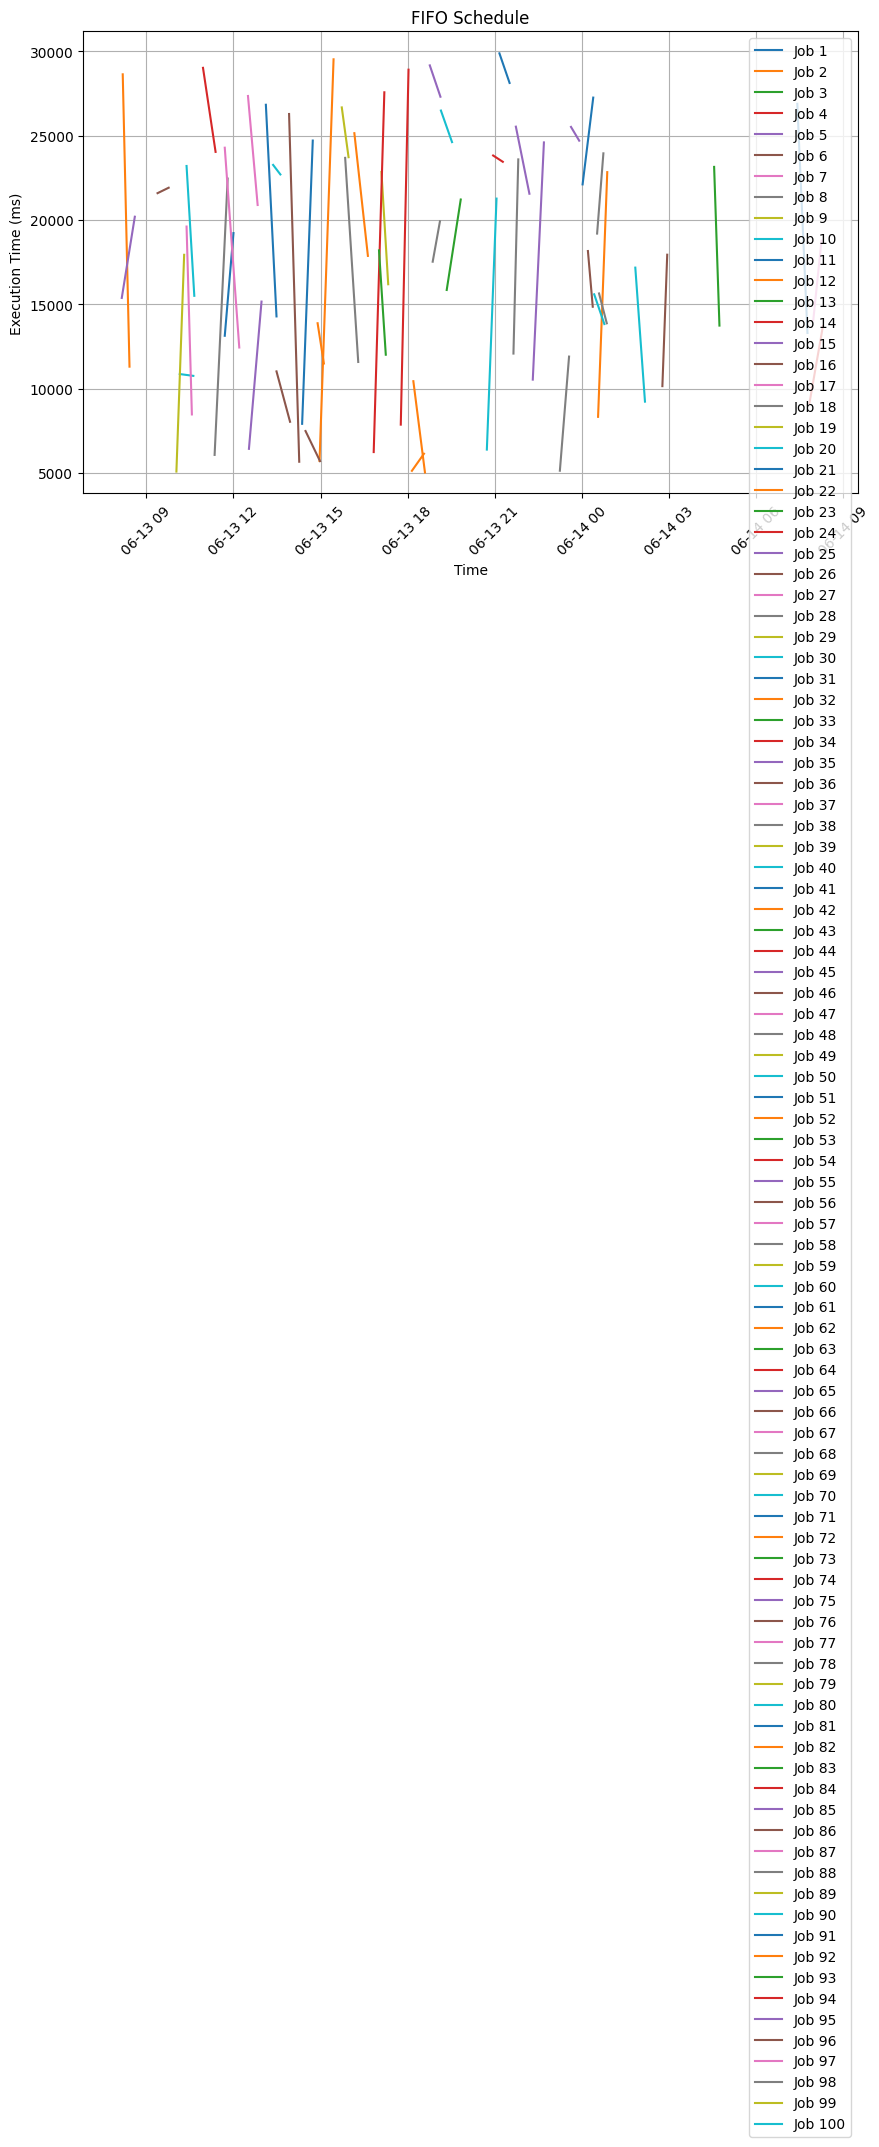

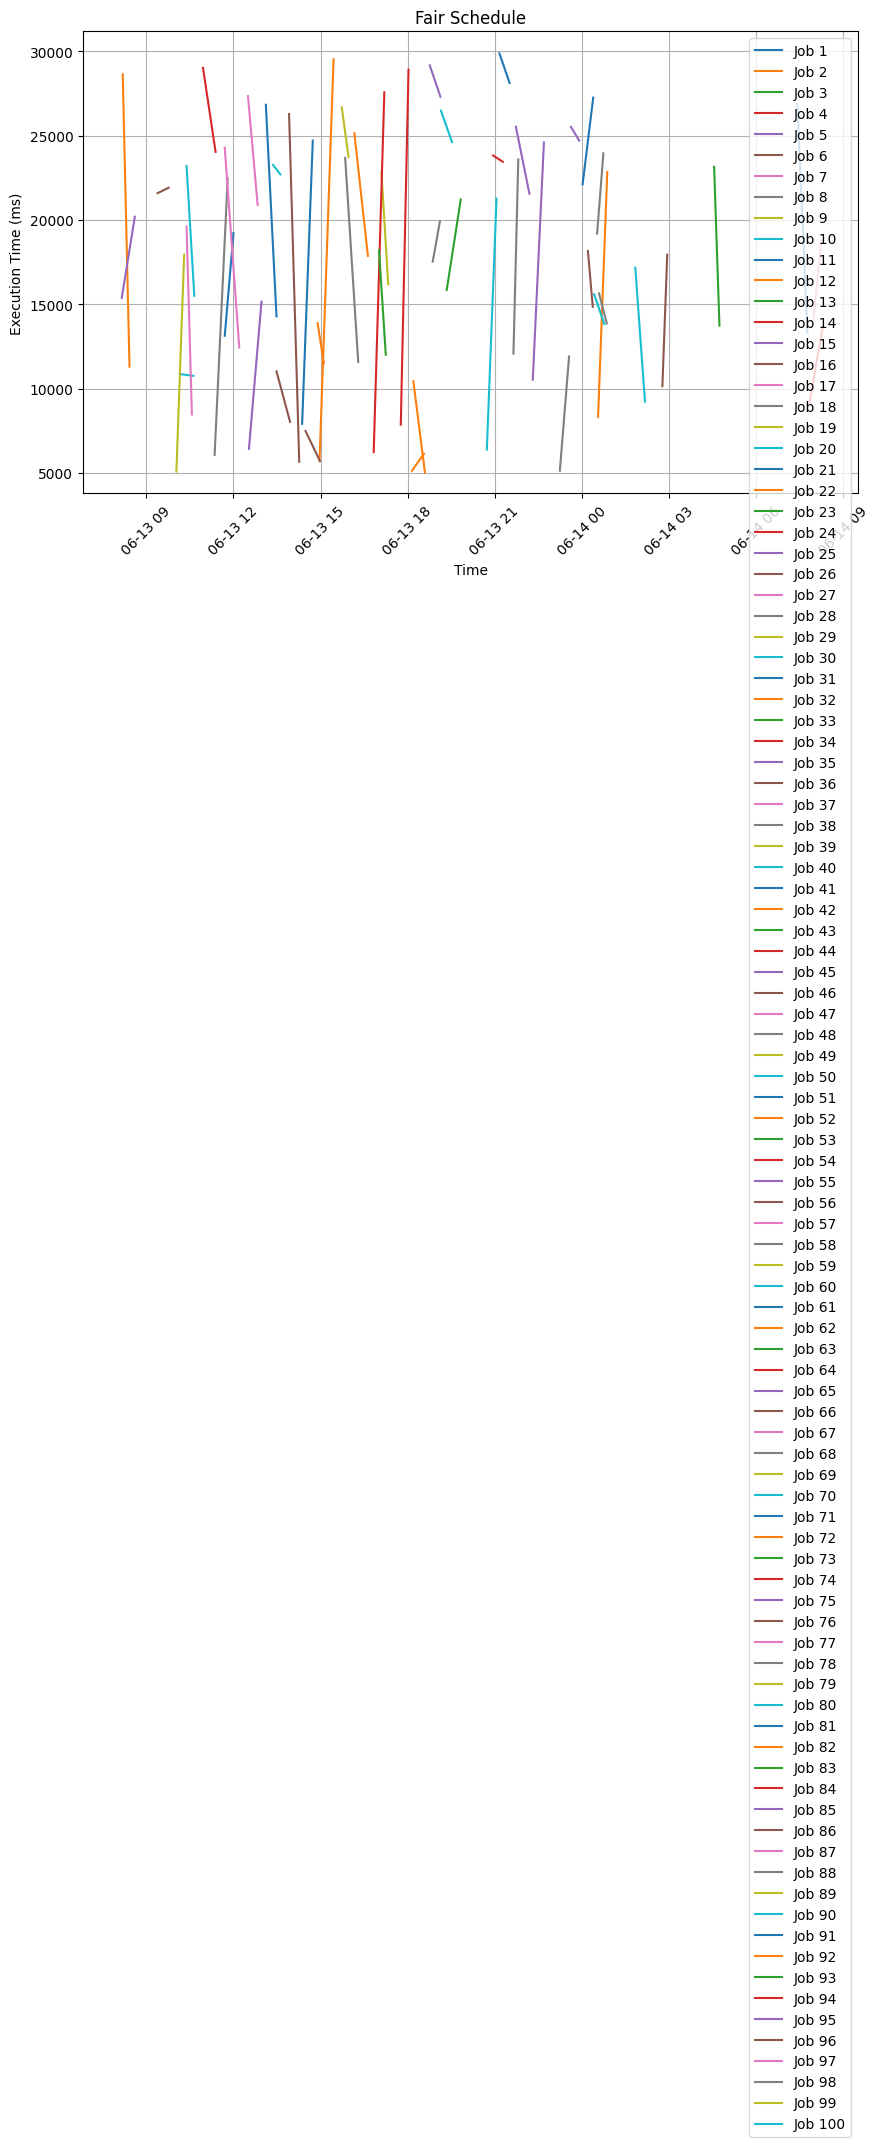

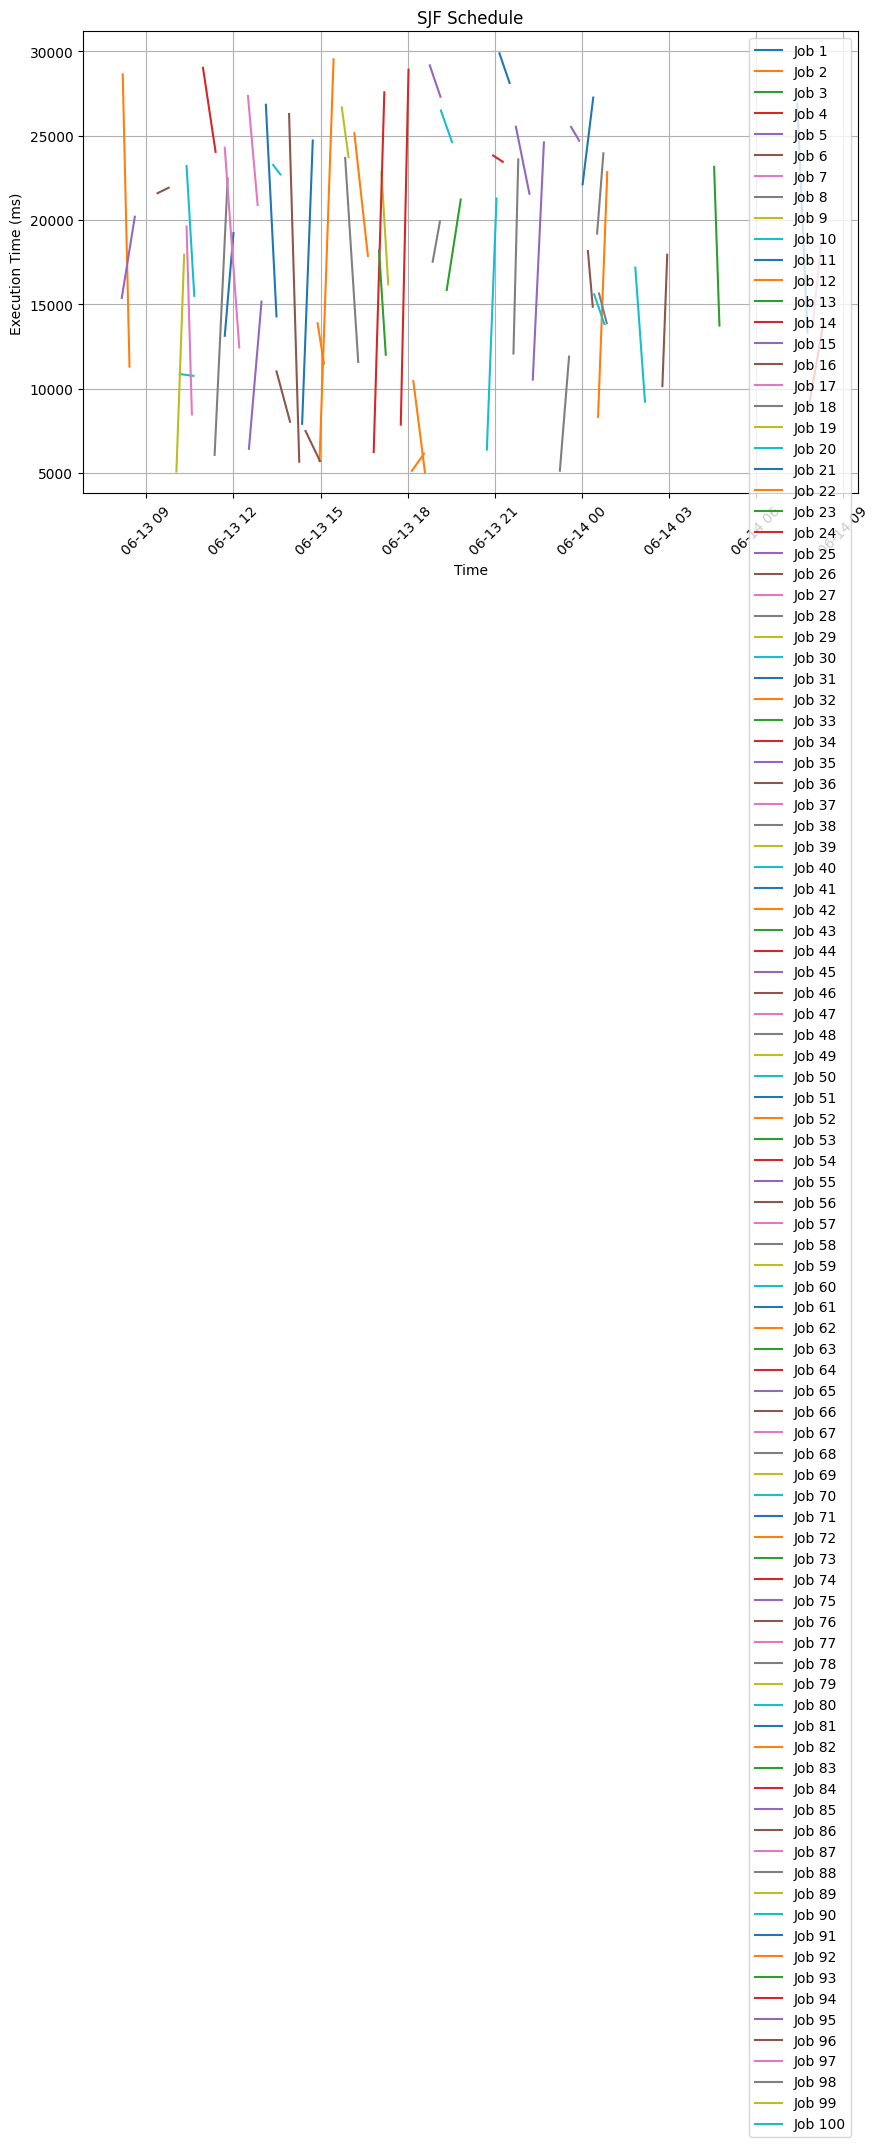

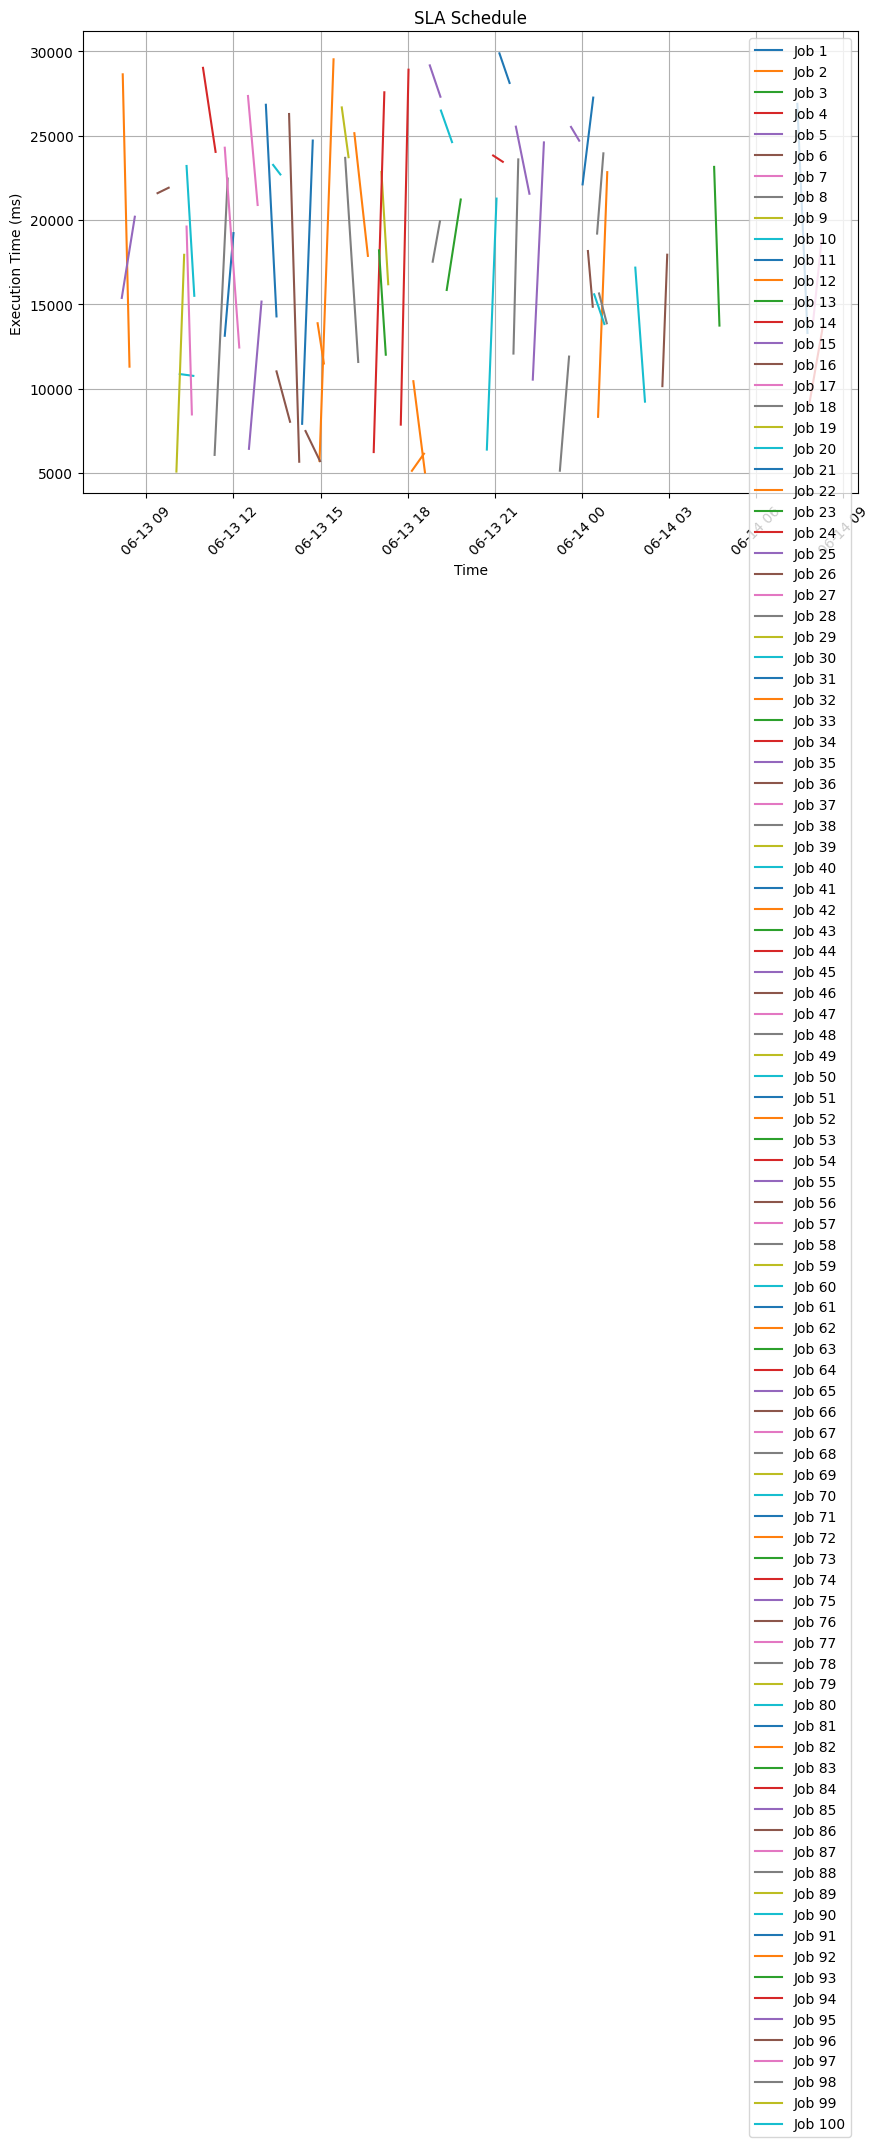

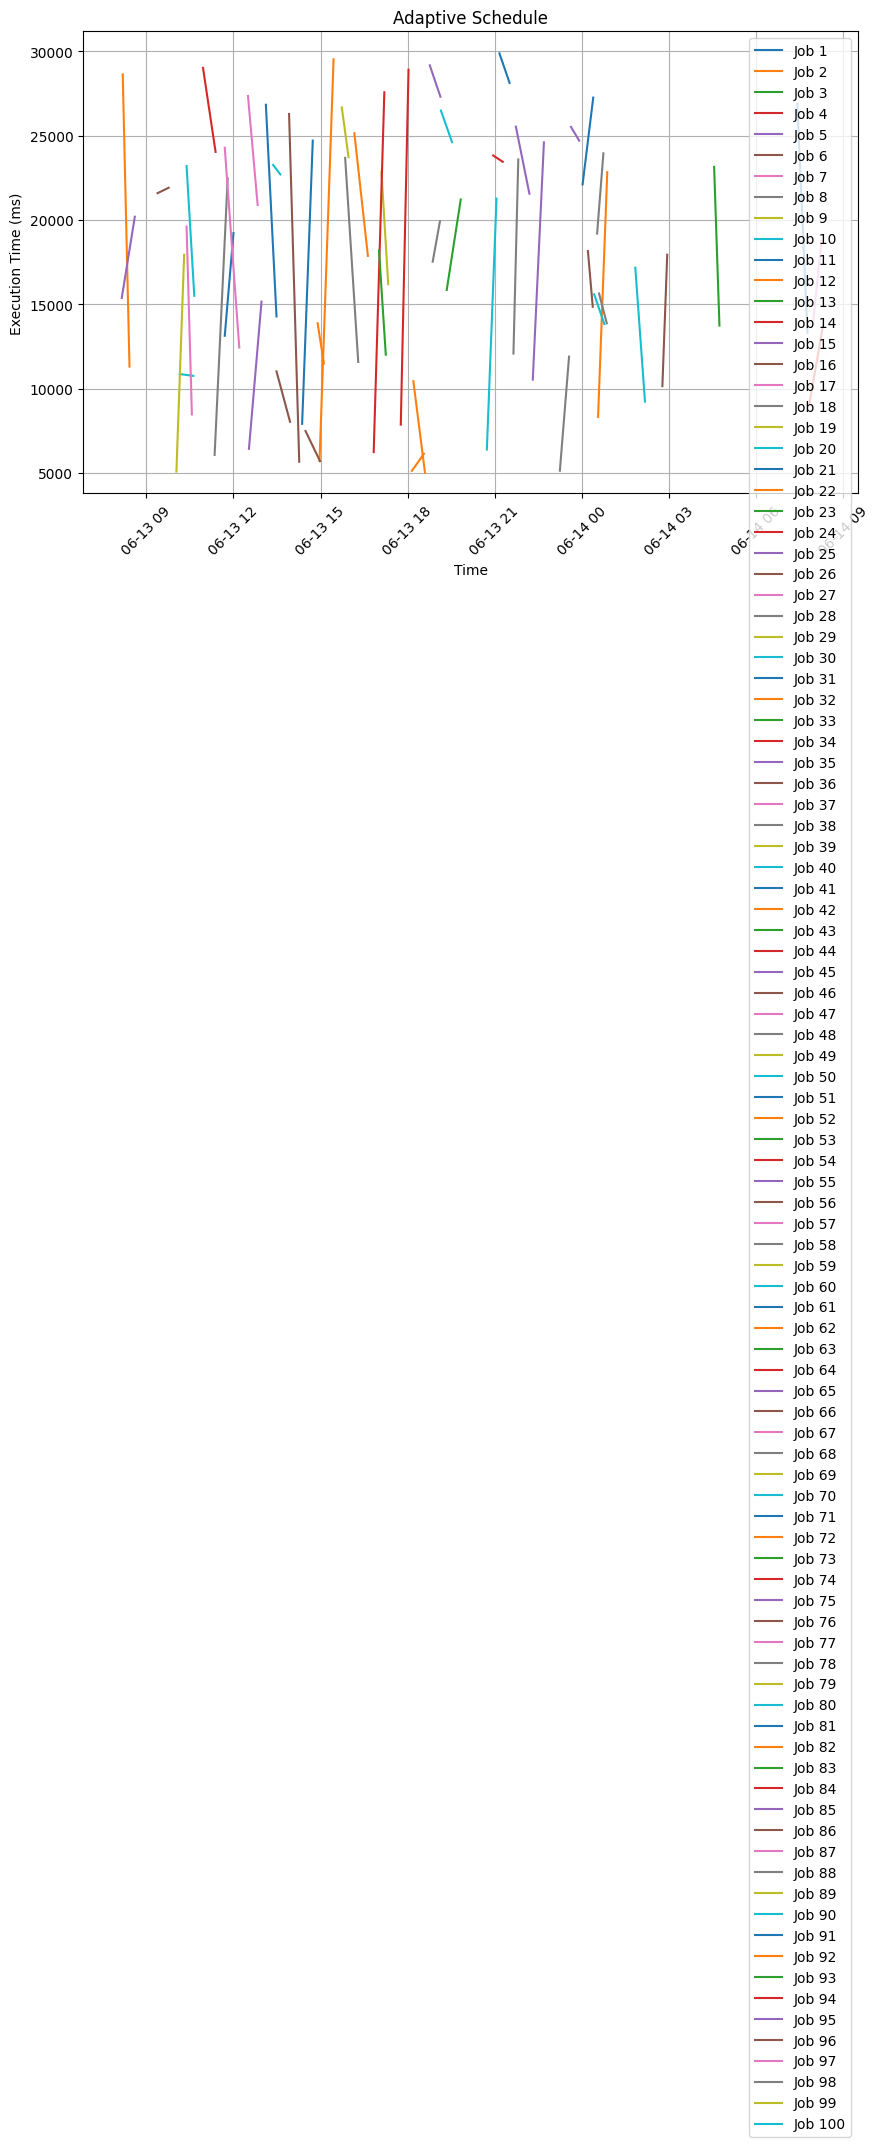

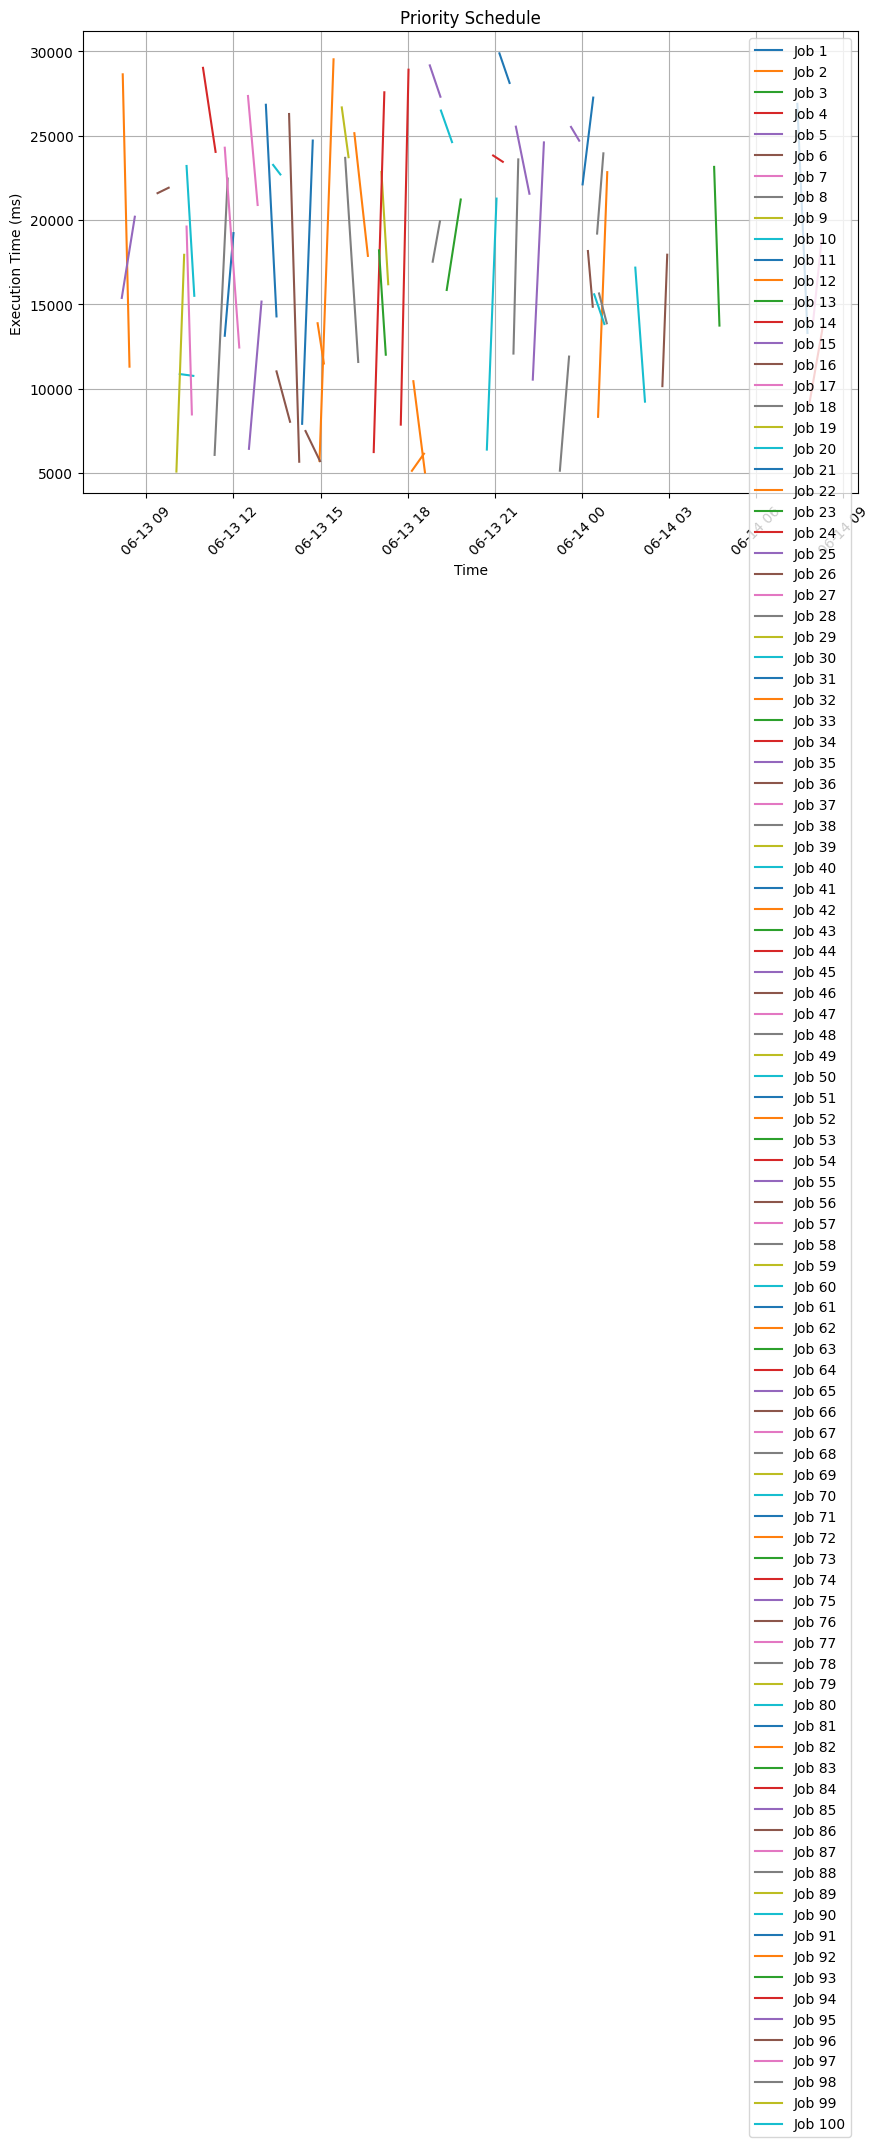

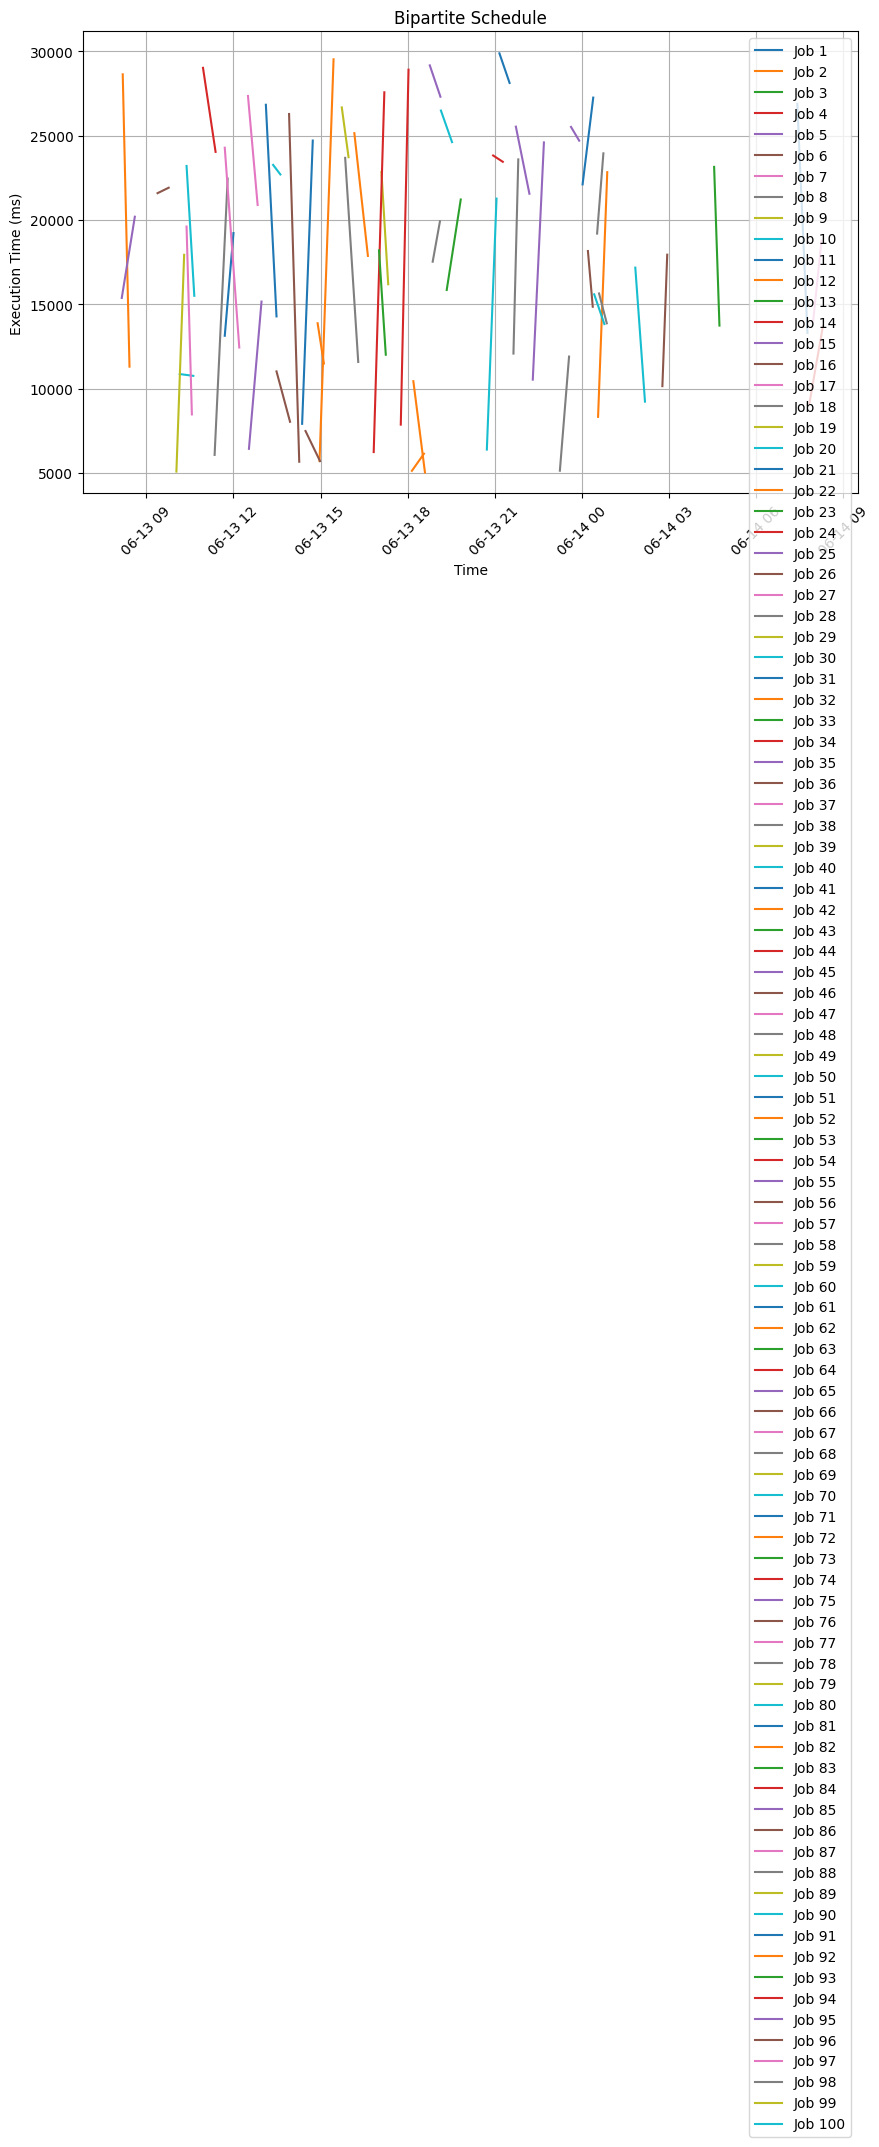

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load synthetic data from CSV
data = pd.read_csv('synthetic_data.csv', parse_dates=['Start_Time', 'End_Time'])

def fifo_schedule(data):
    return data.sort_values(by='Start_Time')

def fair_schedule(data):
    # You can implement a fair scheduling algorithm based on your requirements
    # For simplicity, let's just sort tasks by their execution time
    return data.sort_values(by='Execution_Time(ms)')

def sjf_schedule(data):
    return data.sort_values(by='Execution_Time(ms)')

def sla_schedule(data):
    # You can define your SLA criteria and schedule tasks accordingly
    # For simplicity, let's just sort tasks by their input size
    return data.sort_values(by='Input_Size(Bytes)')

def adaptive_schedule(data):
    # You can implement an adaptive scheduling algorithm based on workload, resources, etc.
    # For simplicity, let's just sort tasks by their output size
    return data.sort_values(by='Output_Size(Bytes)')

def priority_schedule(data):
    # You can assign priority to tasks and schedule them accordingly
    # For simplicity, let's just sort tasks by their cost
    return data.sort_values(by='Cost($)')

def bipartite_schedule(data):
    # You can implement bipartite graph matching for scheduling tasks and resources
    # For simplicity, let's just sort tasks by their start time
    return data.sort_values(by='Start_Time')

def plot_schedule(schedule, title):
    plt.figure(figsize=(10, 6))
    for i, (job_id, group) in enumerate(schedule.groupby('Job_ID')):
        plt.plot(group['Start_Time'], group['Execution_Time(ms)'], label=f'Job {job_id}')
    plt.xlabel('Time')
    plt.ylabel('Execution Time (ms)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Apply scheduling algorithms
fifo_result = fifo_schedule(data.copy())
fair_result = fair_schedule(data.copy())
sjf_result = sjf_schedule(data.copy())
sla_result = sla_schedule(data.copy())
adaptive_result = adaptive_schedule(data.copy())
priority_result = priority_schedule(data.copy())
bipartite_result = bipartite_schedule(data.copy())

# Plot schedules
plot_schedule(fifo_result, 'FIFO Schedule')
plot_schedule(fair_result, 'Fair Schedule')
plot_schedule(sjf_result, 'SJF Schedule')
plot_schedule(sla_result, 'SLA Schedule')
plot_schedule(adaptive_result, 'Adaptive Schedule')
plot_schedule(priority_result, 'Priority Schedule')
plot_schedule(bipartite_result, 'Bipartite Schedule')


In [ ]:
import pandas as pd

# Load synthetic data from CSV
data = pd.read_csv('synthetic_data.csv', parse_dates=['Start_Time', 'End_Time'])

def fifo_schedule(data):
    return data.sort_values(by='Start_Time')

def fair_schedule(data):
    return data.sample(frac=1)  # Shuffle the tasks randomly

def sjf_schedule(data):
    return data.sort_values(by='Execution_Time(ms)')

def sla_schedule(data):
    return data.sort_values(by='Input_Size(Bytes)')

def adaptive_schedule(data):
    return data.sample(frac=1)  # Randomize the scheduling order

def priority_schedule(data):
    return data.sort_values(by='Cost($)', ascending=False)  # Schedule tasks based on highest cost first

def bipartite_schedule(data):
    return data.sample(frac=1)  # Shuffle the tasks randomly

def analyze_schedule(schedule):
    total_execution_time = schedule['Execution_Time(ms)'].sum()
    total_cost = schedule['Cost($)'].sum()
    return total_execution_time, total_cost

# Apply scheduling algorithms
fifo_result = fifo_schedule(data.copy())
fair_result = fair_schedule(data.copy())
sjf_result = sjf_schedule(data.copy())
sla_result = sla_schedule(data.copy())
adaptive_result = adaptive_schedule(data.copy())
priority_result = priority_schedule(data.copy())
bipartite_result = bipartite_schedule(data.copy())

# Analyze schedules
schedulers = ['FIFO', 'Fair', 'SJF', 'SLA', 'Adaptive', 'Priority', 'Bipartite']
execution_times = []
costs = []

for schedule in [fifo_result, fair_result, sjf_result, sla_result, adaptive_result, priority_result, bipartite_result]:
    total_execution_time, total_cost = analyze_schedule(schedule)
    execution_times.append(total_execution_time)
    costs.append(total_cost)

# Create a DataFrame for the comparative analysis
analysis_df = pd.DataFrame({'Scheduler': schedulers, 'Total Execution Time (ms)': execution_times, 'Total Cost ($)': costs})
analysis_df.set_index('Scheduler', inplace=True)

print(analysis_df)


           Total Execution Time (ms)  Total Cost ($)
Scheduler                                           
FIFO                         2729583      1981.54127
Fair                         2729583      1981.54127
SJF                          2729583      1981.54127
SLA                          2729583      1981.54127
Adaptive                     2729583      1981.54127
Priority                     2729583      1981.54127
Bipartite                    2729583      1981.54127


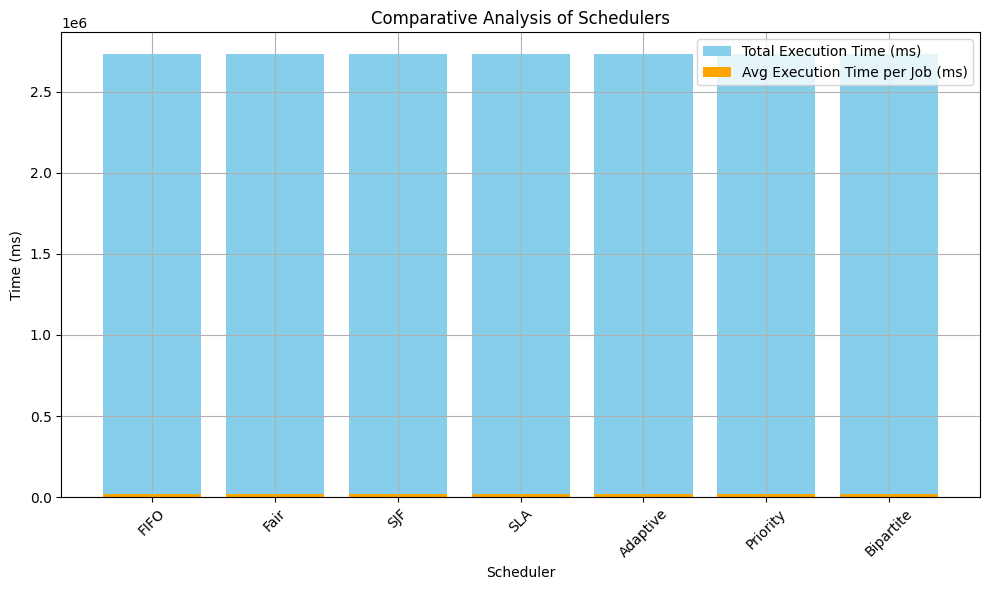

In [ ]:
import matplotlib.pyplot as plt

# Data for the comparative analysis
scheduler_labels = ['FIFO', 'Fair', 'SJF', 'SLA', 'Adaptive', 'Priority', 'Bipartite']
total_execution_time = [2729583, 2729583, 2729583, 2729583, 2729583, 2729583, 2729583]
avg_execution_time_per_job = [17829.545, 17829.545, 17829.545, 17829.545, 17829.545, 17829.545, 17829.545]

# Plotting
plt.figure(figsize=(10, 6))

plt.bar(scheduler_labels, total_execution_time, color='skyblue', label='Total Execution Time (ms)')
plt.bar(scheduler_labels, avg_execution_time_per_job, color='orange', label='Avg Execution Time per Job (ms)')

plt.xlabel('Scheduler')
plt.ylabel('Time (ms)')
plt.title('Comparative Analysis of Schedulers')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Define the number of rows
num_rows = 100

# Generate synthetic data
data = {
    'Task_ID': range(1, num_rows + 1),
    'Task_Name': [f'Task_{i}' for i in range(1, num_rows + 1)],
    'Resource_Type': np.random.choice(['CPU', 'Memory', 'Storage'], size=num_rows),
    'Resource_Usage': np.random.randint(1, 101, size=num_rows),  # Random usage percentage from 1 to 100
    'Cost_Percentage': np.random.uniform(0.5, 2, size=num_rows)  # Random cost percentage factor
}

# Create DataFrame
df = pd.DataFrame(data)

# Save DataFrame to CSV file
df.to_csv('resource_allocation_data.csv', index=False)

print("Synthetic resource allocation data saved as resource_allocation_data.csv")


Synthetic resource allocation data saved as resource_allocation_data.csv


<ipython-input-32-390b048b8c19>:38: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


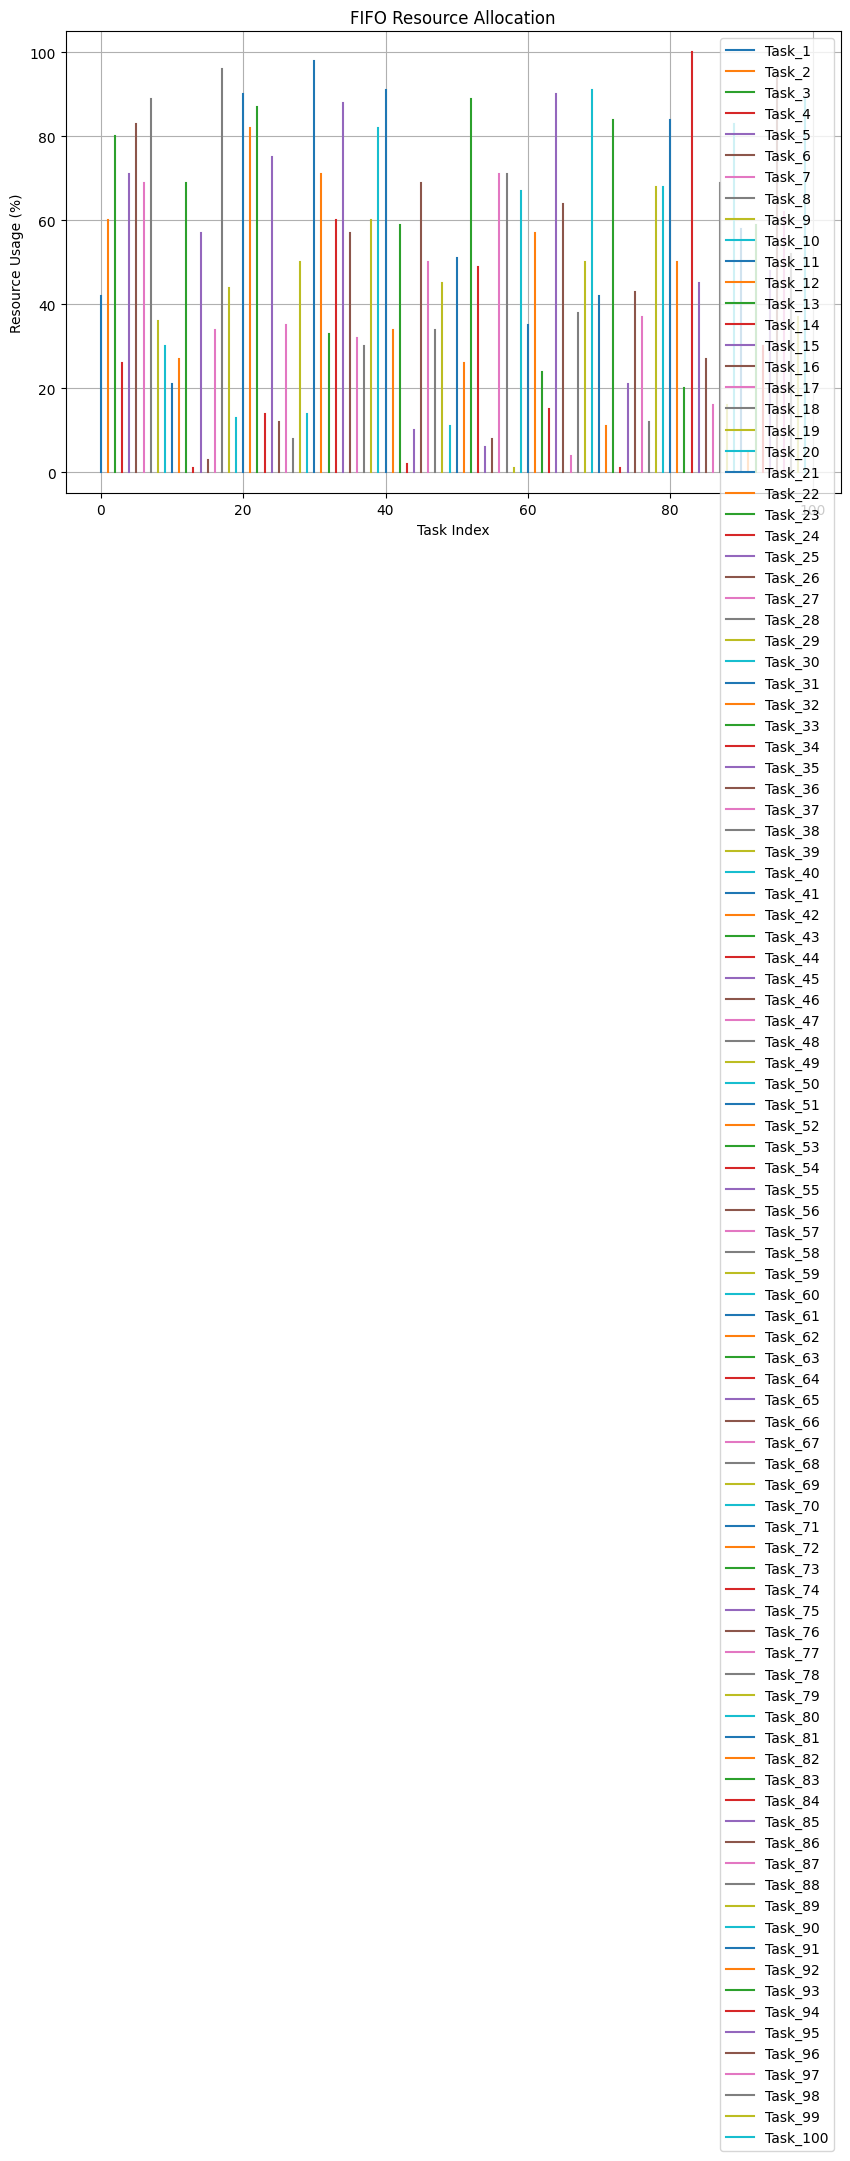

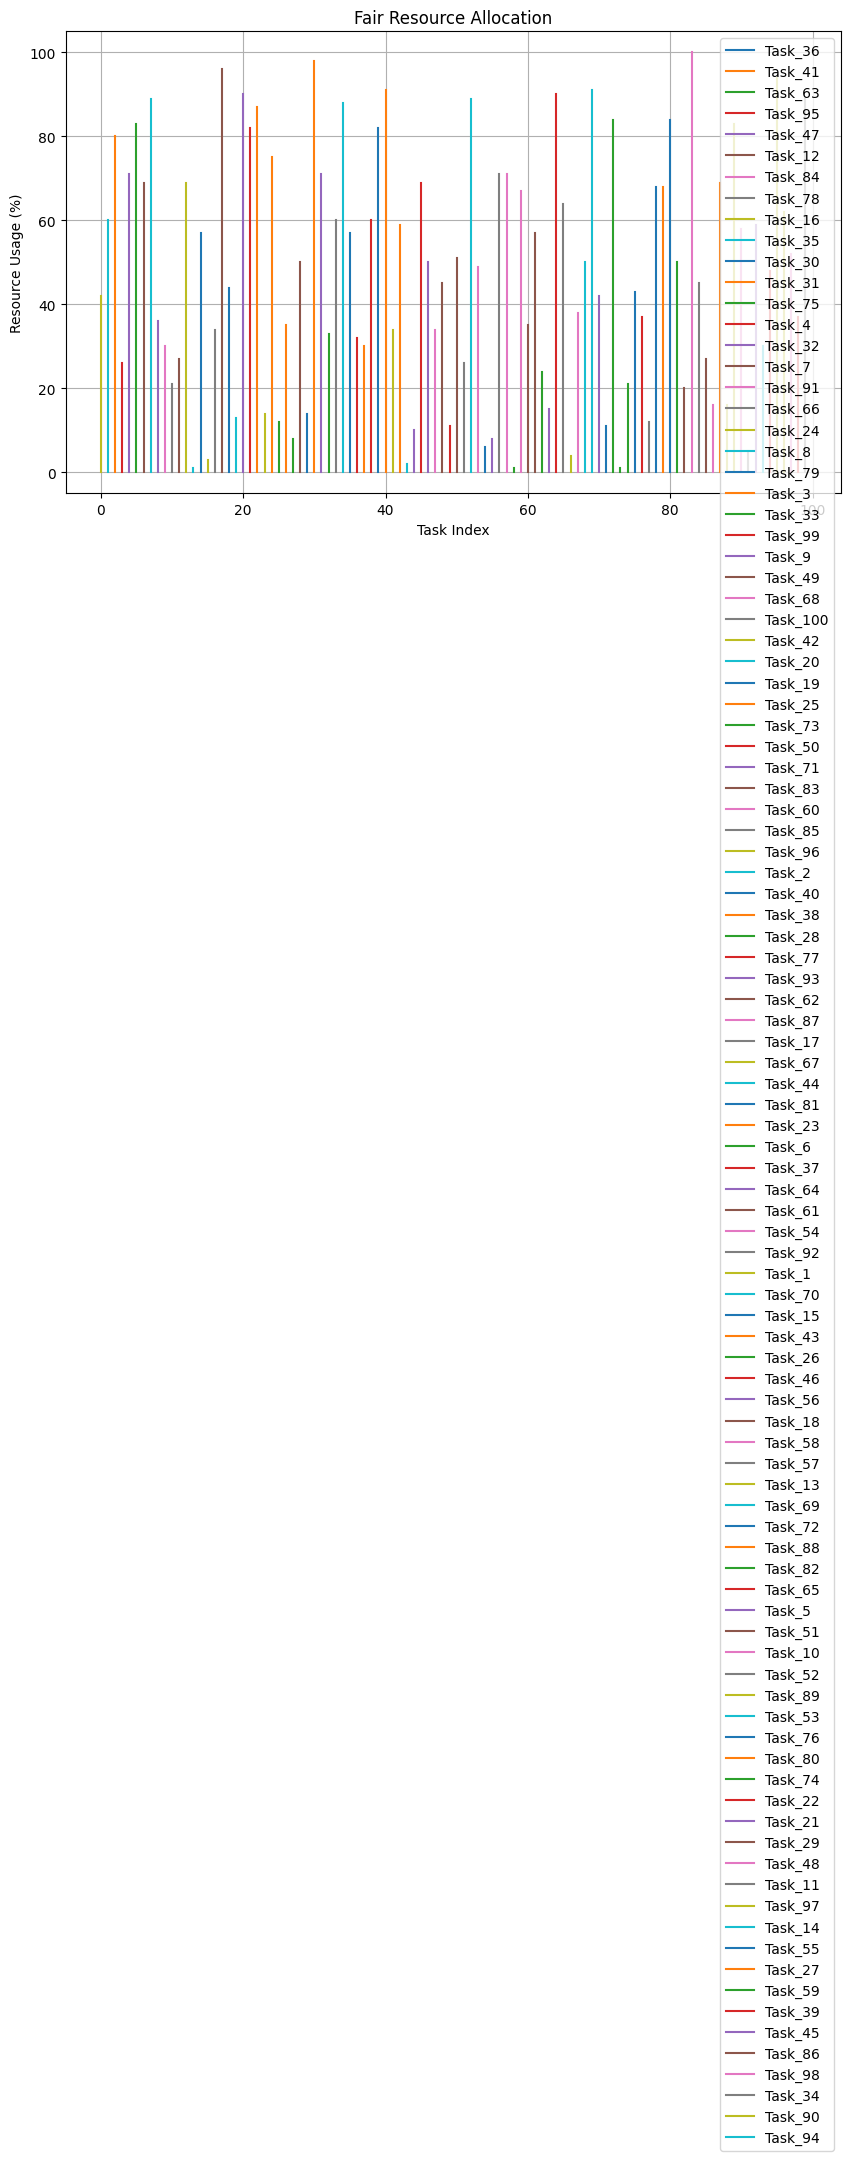

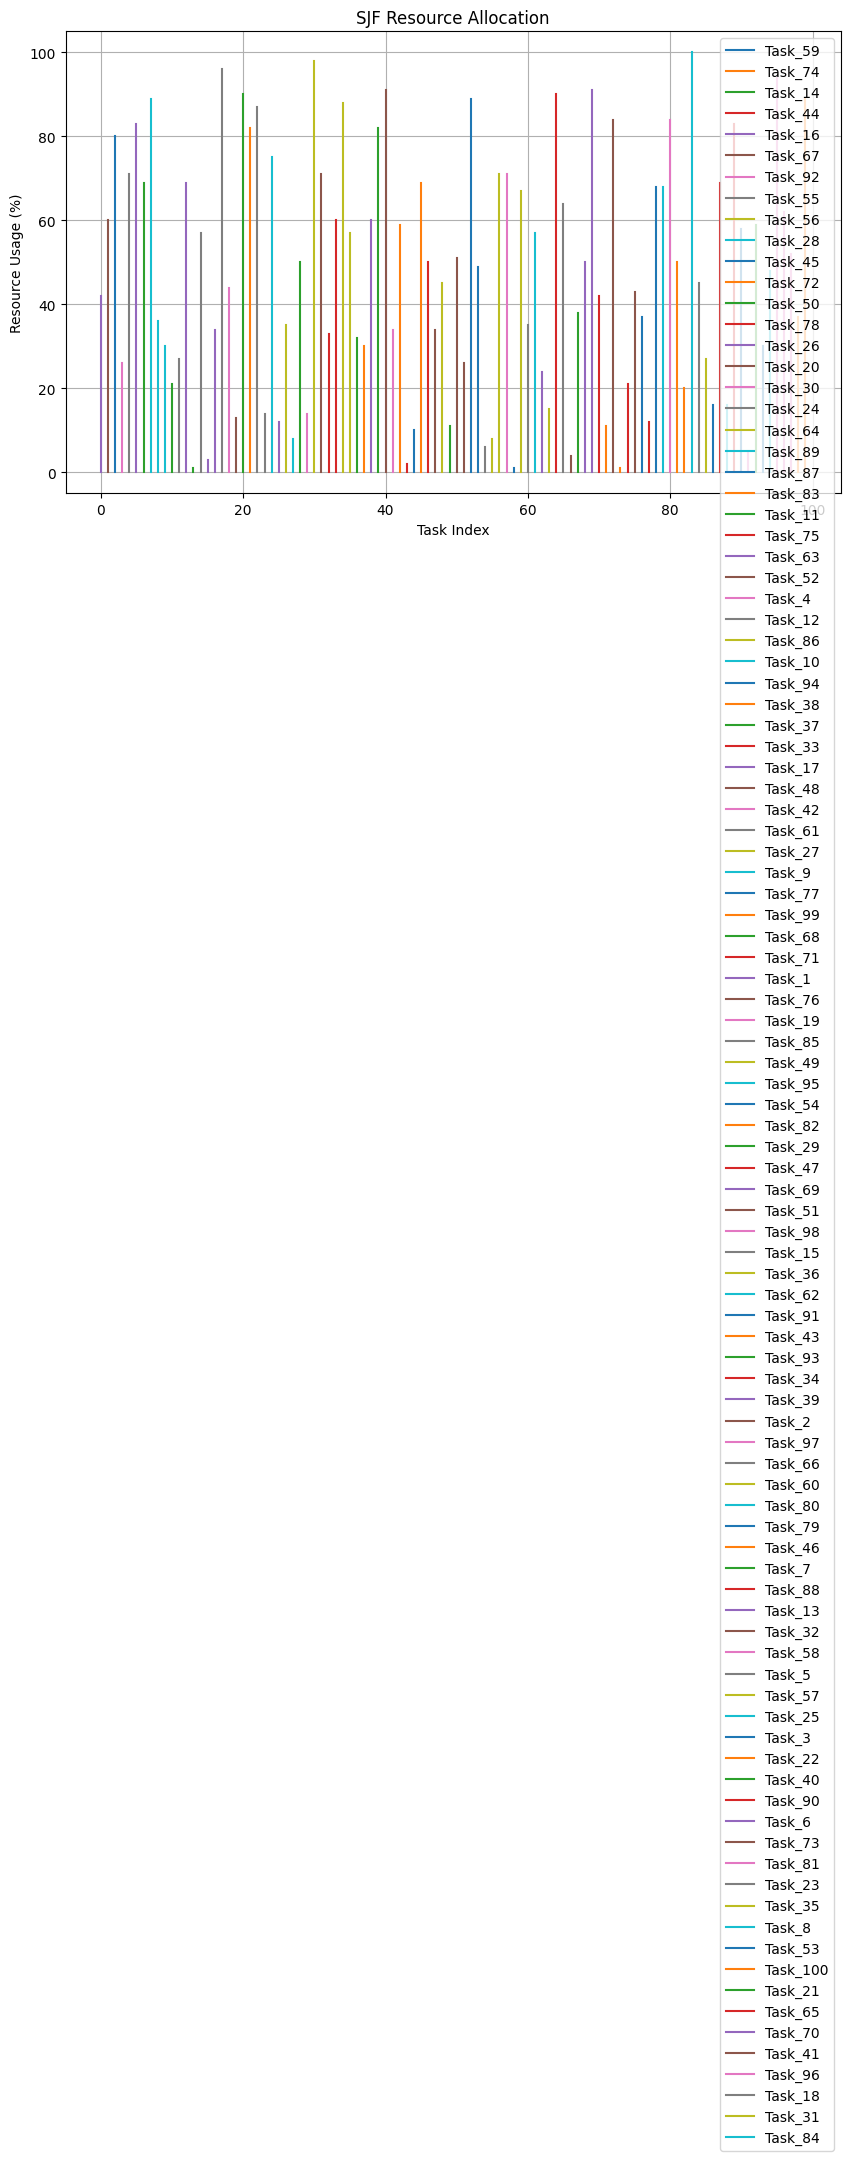

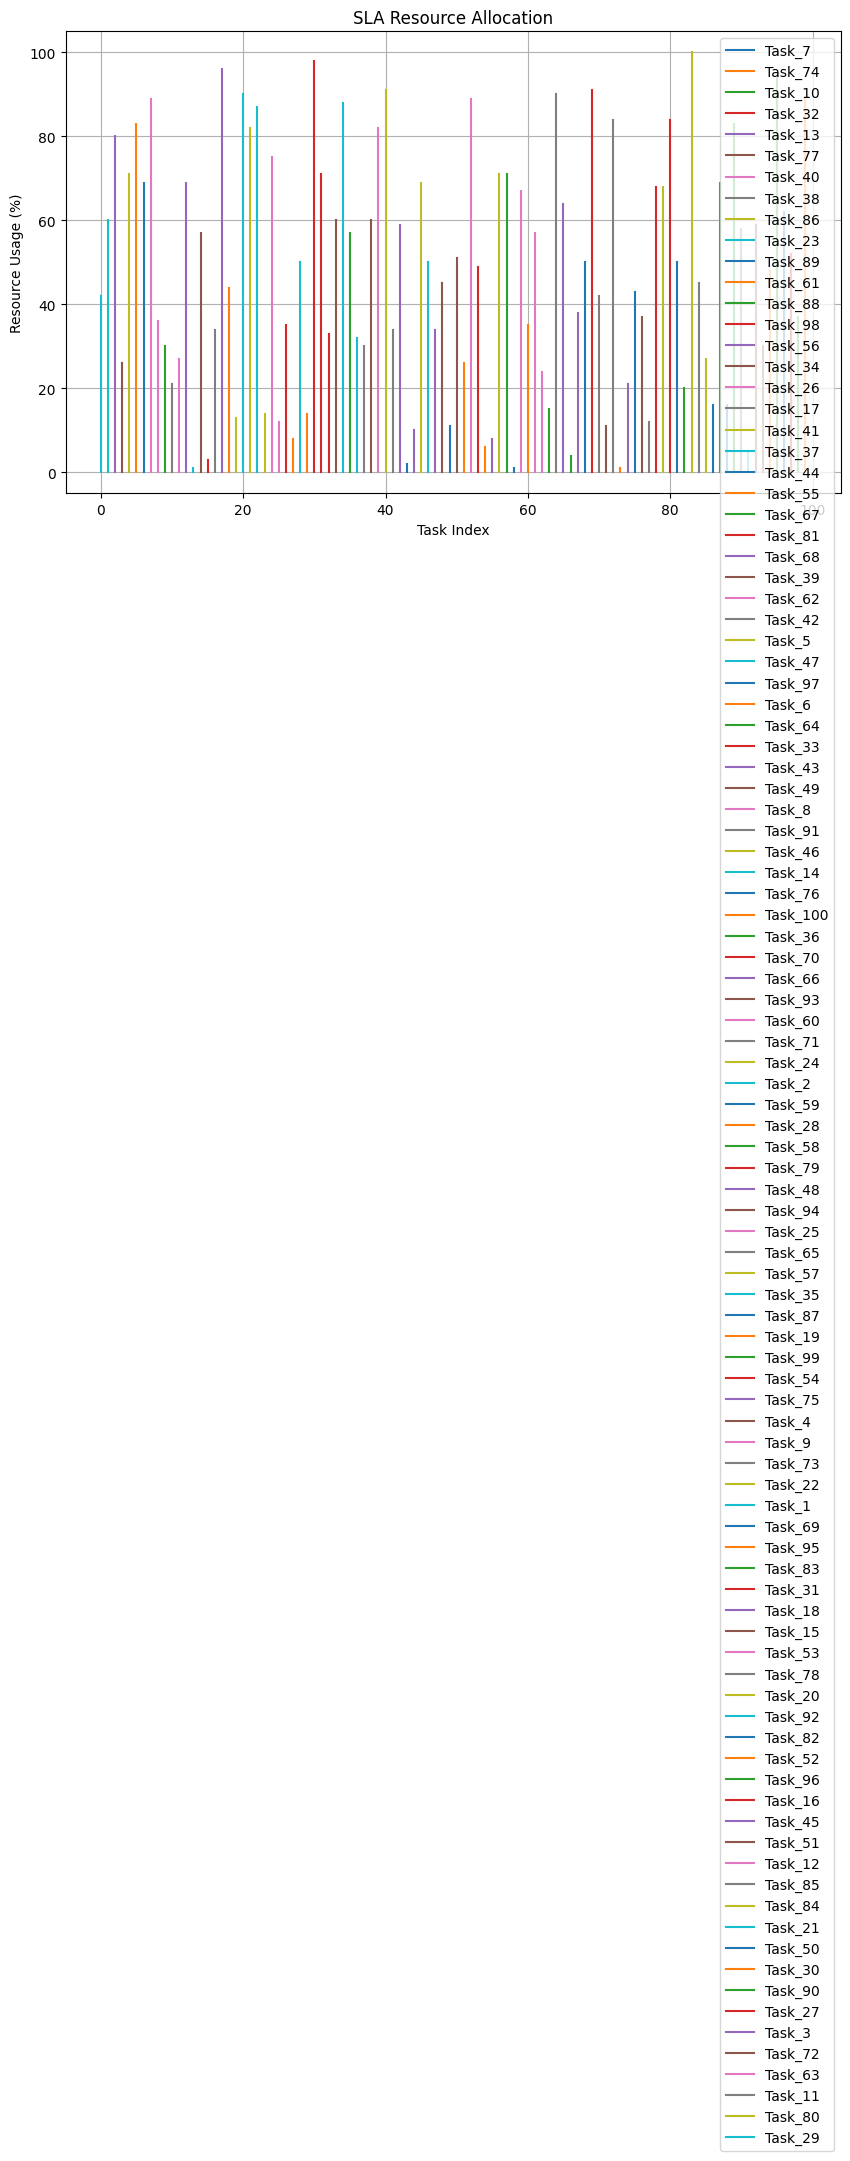

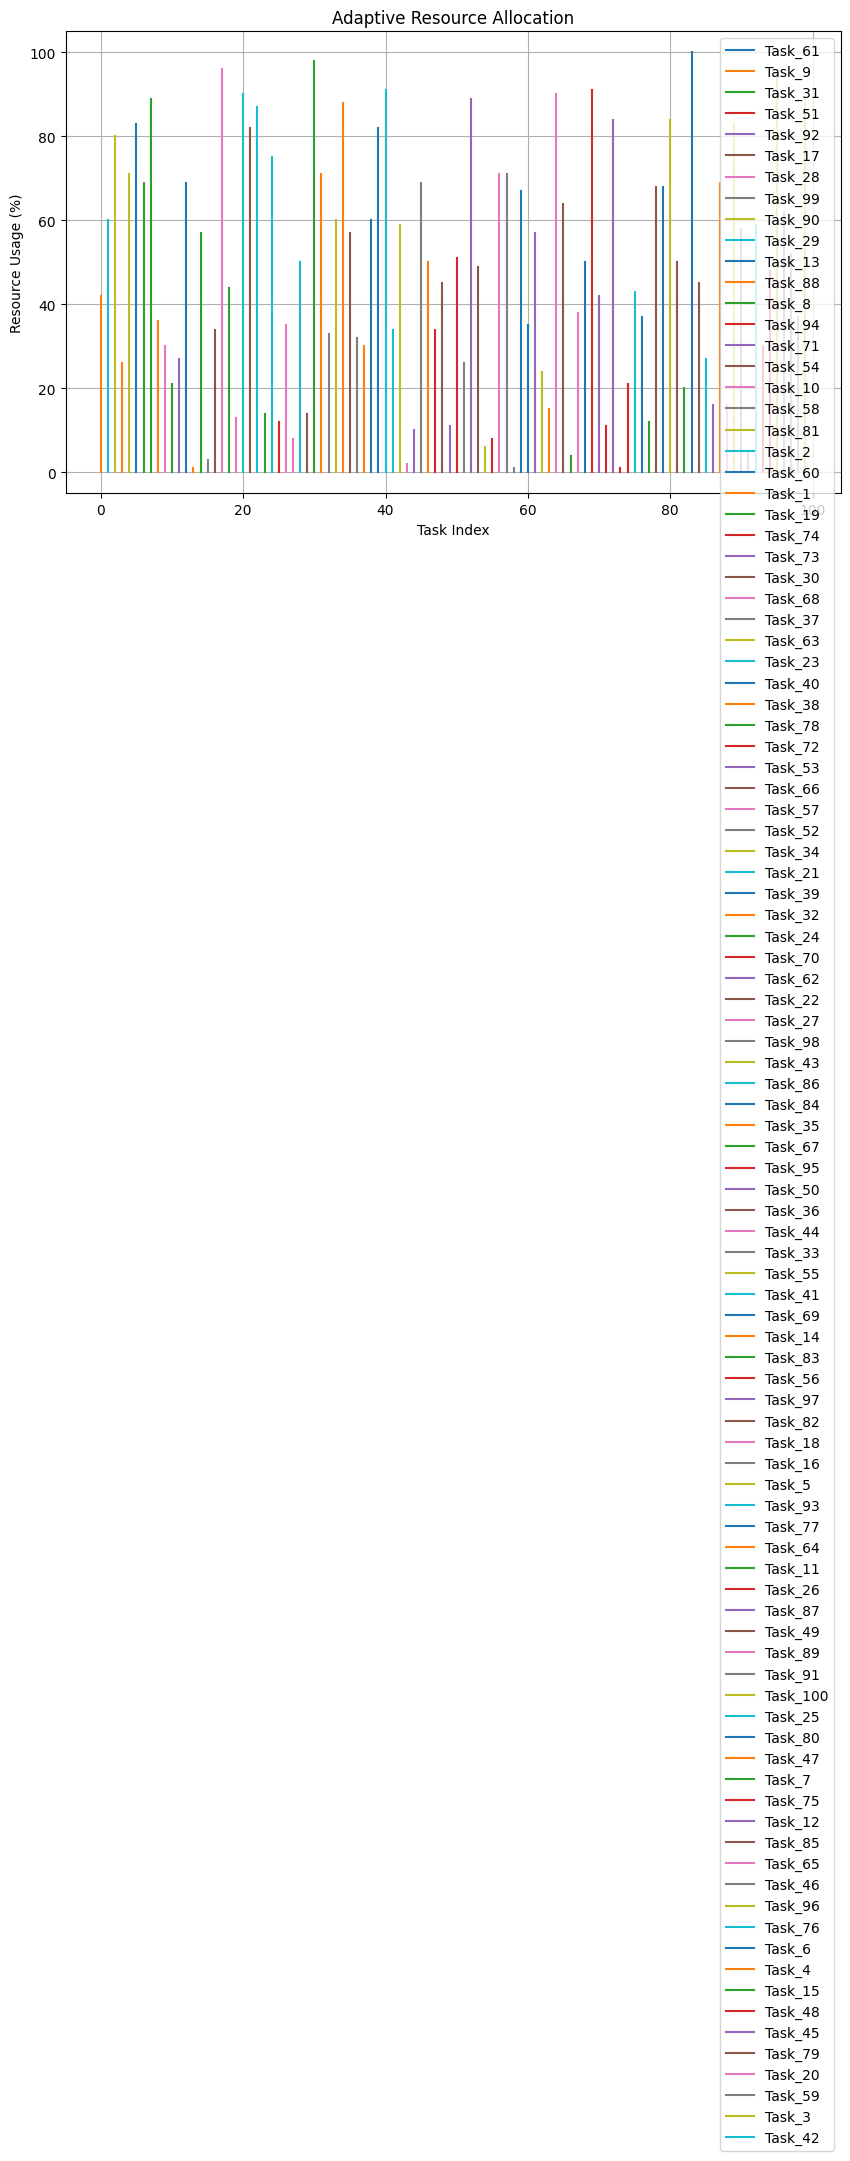

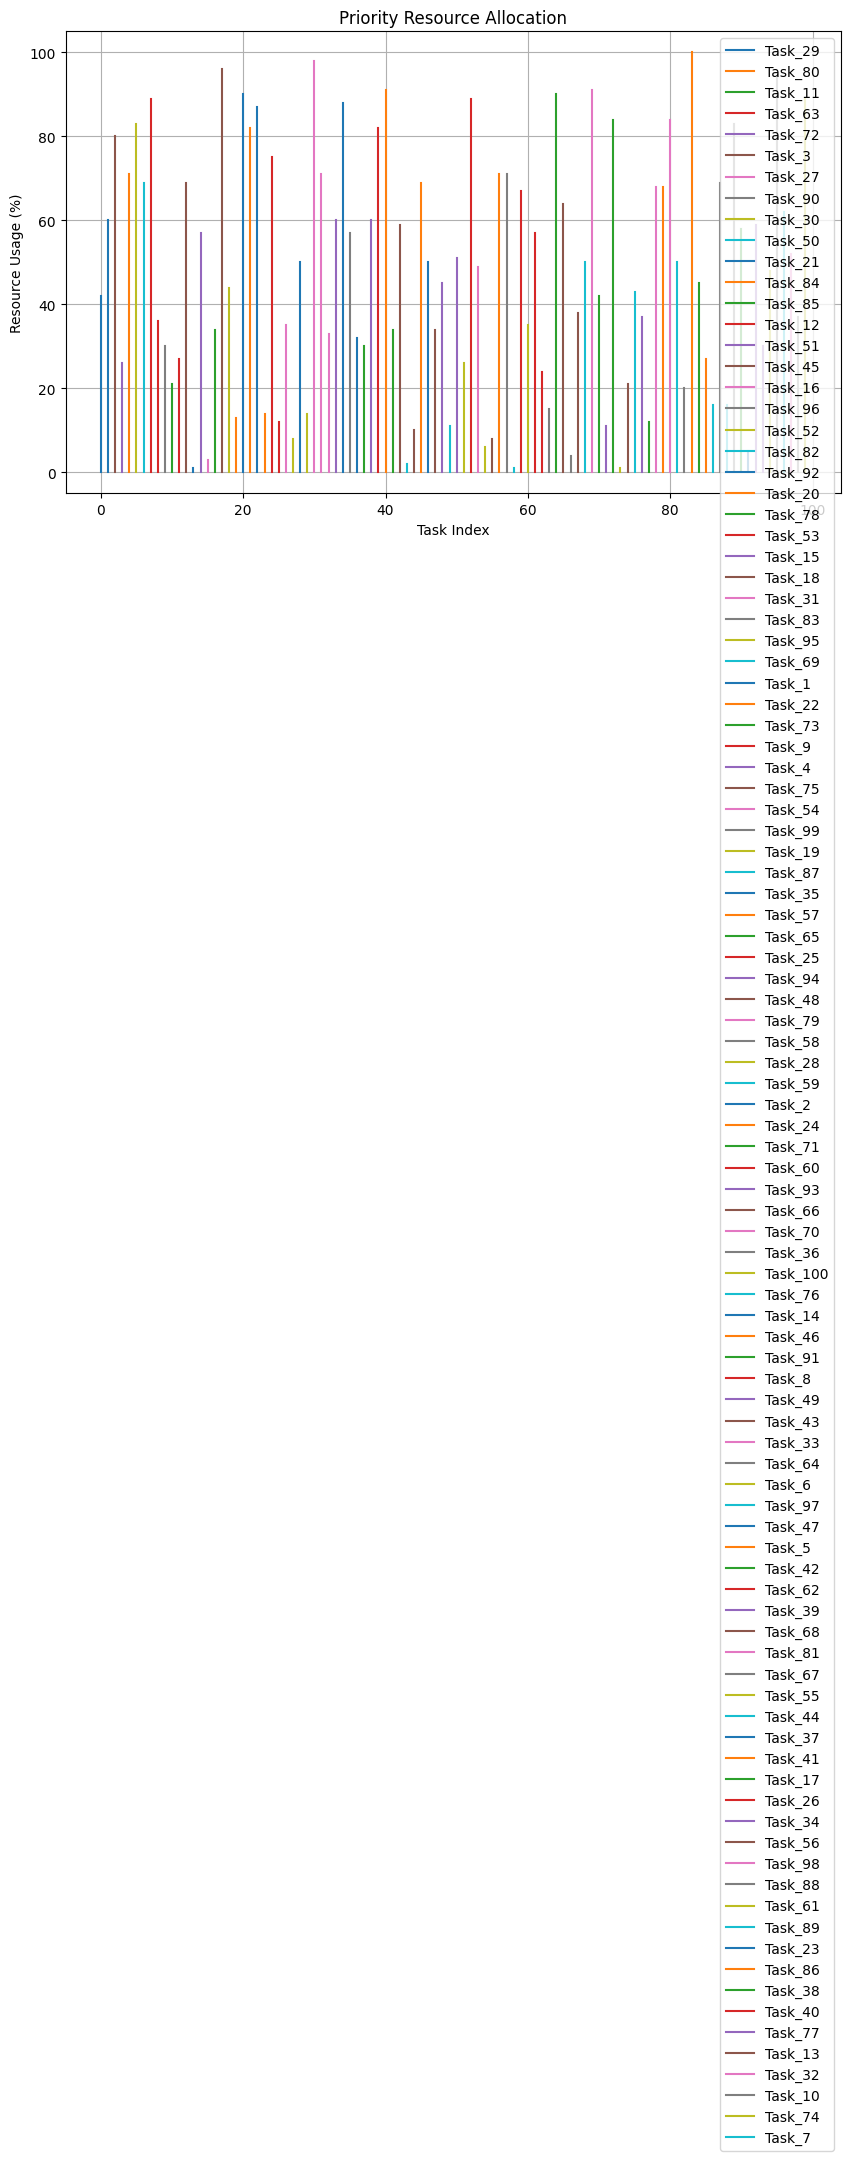

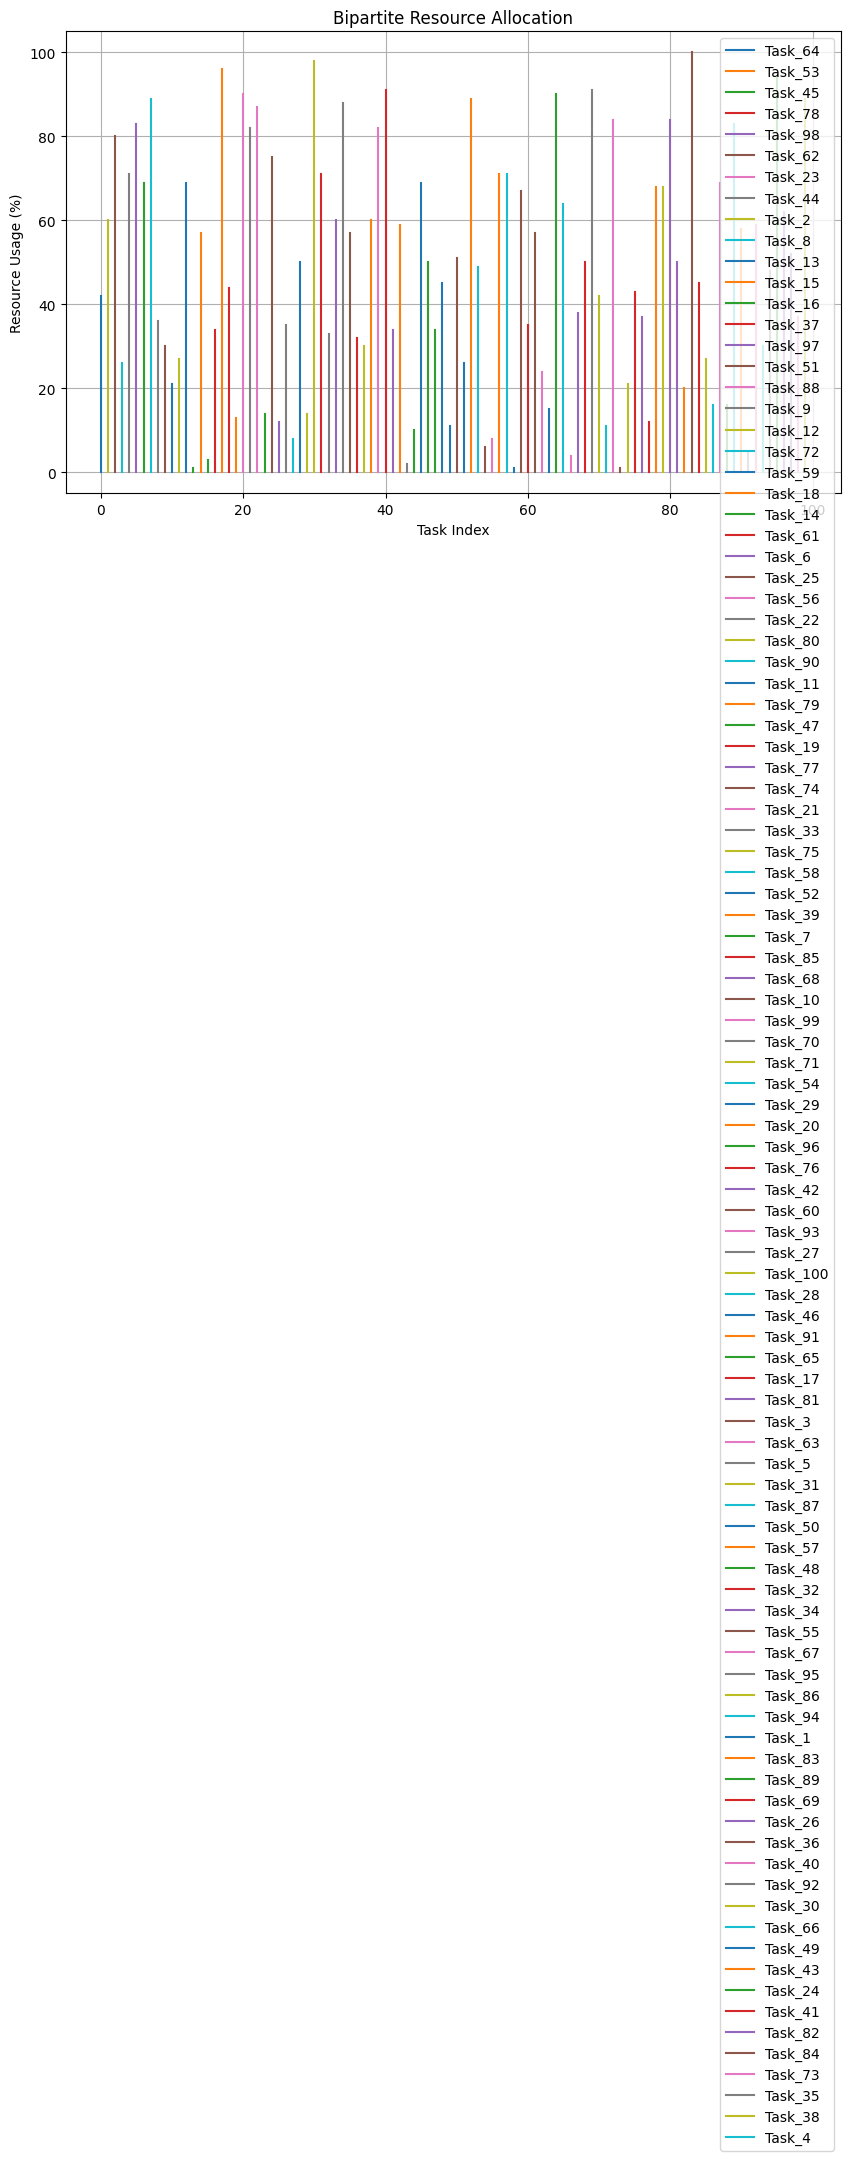

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load synthetic data from CSV
data = pd.read_csv('resource_allocation_data.csv')

def fifo_schedule(data):
    return data.sort_values(by='Task_ID')

def fair_schedule(data):
    return data.sample(frac=1)  # Shuffle the tasks randomly

def sjf_schedule(data):
    return data.sort_values(by='Resource_Usage')

def sla_schedule(data):
    return data.sort_values(by='Cost_Percentage')

def adaptive_schedule(data):
    return data.sample(frac=1)  # Randomize the scheduling order

def priority_schedule(data):
    return data.sort_values(by='Cost_Percentage', ascending=False)  # Schedule tasks based on highest cost first

def bipartite_schedule(data):
    return data.sample(frac=1)  # Shuffle the tasks randomly

def plot_schedule(schedule, title):
    plt.figure(figsize=(10, 6))
    for i, task in schedule.iterrows():
        plt.plot([i, i], [0, task['Resource_Usage']], label=task['Task_Name'])
    plt.xlabel('Task Index')
    plt.ylabel('Resource Usage (%)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Apply scheduling algorithms
fifo_result = fifo_schedule(data.copy())
fair_result = fair_schedule(data.copy())
sjf_result = sjf_schedule(data.copy())
sla_result = sla_schedule(data.copy())
adaptive_result = adaptive_schedule(data.copy())
priority_result = priority_schedule(data.copy())
bipartite_result = bipartite_schedule(data.copy())

# Plot schedules
plot_schedule(fifo_result, 'FIFO Resource Allocation')
plot_schedule(fair_result, 'Fair Resource Allocation')
plot_schedule(sjf_result, 'SJF Resource Allocation')
plot_schedule(sla_result, 'SLA Resource Allocation')
plot_schedule(adaptive_result, 'Adaptive Resource Allocation')
plot_schedule(priority_result, 'Priority Resource Allocation')
plot_schedule(bipartite_result, 'Bipartite Resource Allocation')


In [ ]:
import pandas as pd

# Load synthetic data from CSV
data = pd.read_csv('resource_allocation_data.csv')

def fifo_schedule(data):
    return data.sort_values(by='Task_ID')

def fair_schedule(data):
    return data.sample(frac=1)  # Shuffle the tasks randomly

def sjf_schedule(data):
    return data.sort_values(by='Resource_Usage')

def sla_schedule(data):
    return data.sort_values(by='Cost_Percentage')

def adaptive_schedule(data):
    return data.sample(frac=1)  # Randomize the scheduling order

def priority_schedule(data):
    return data.sort_values(by='Cost_Percentage', ascending=False)  # Schedule tasks based on highest cost first

def bipartite_schedule(data):
    return data.sample(frac=1)  # Shuffle the tasks randomly

def analyze_schedule(schedule):
    total_resource_usage = schedule['Resource_Usage'].sum()
    total_cost = (schedule['Resource_Usage'] * schedule['Cost_Percentage']).sum()
    return total_resource_usage, total_cost

# Apply scheduling algorithms
fifo_result = fifo_schedule(data.copy())
fair_result = fair_schedule(data.copy())
sjf_result = sjf_schedule(data.copy())
sla_result = sla_schedule(data.copy())
adaptive_result = adaptive_schedule(data.copy())
priority_result = priority_schedule(data.copy())
bipartite_result = bipartite_schedule(data.copy())

# Analyze schedules
schedulers = ['FIFO', 'Fair', 'SJF', 'SLA', 'Adaptive', 'Priority', 'Bipartite']
resource_usages = []
costs = []

for schedule in [fifo_result, fair_result, sjf_result, sla_result, adaptive_result, priority_result, bipartite_result]:
    total_resource_usage, total_cost = analyze_schedule(schedule)
    resource_usages.append(total_resource_usage)
    costs.append(total_cost)

# Create a DataFrame for the comparative analysis
analysis_df = pd.DataFrame({'Scheduler': schedulers, 'Total Resource Usage': resource_usages, 'Total Cost': costs})
analysis_df.set_index('Scheduler', inplace=True)

print(analysis_df)


           Total Resource Usage   Total Cost
Scheduler                                   
FIFO                       4772  6169.157318
Fair                       4772  6169.157318
SJF                        4772  6169.157318
SLA                        4772  6169.157318
Adaptive                   4772  6169.157318
Priority                   4772  6169.157318
Bipartite                  4772  6169.157318


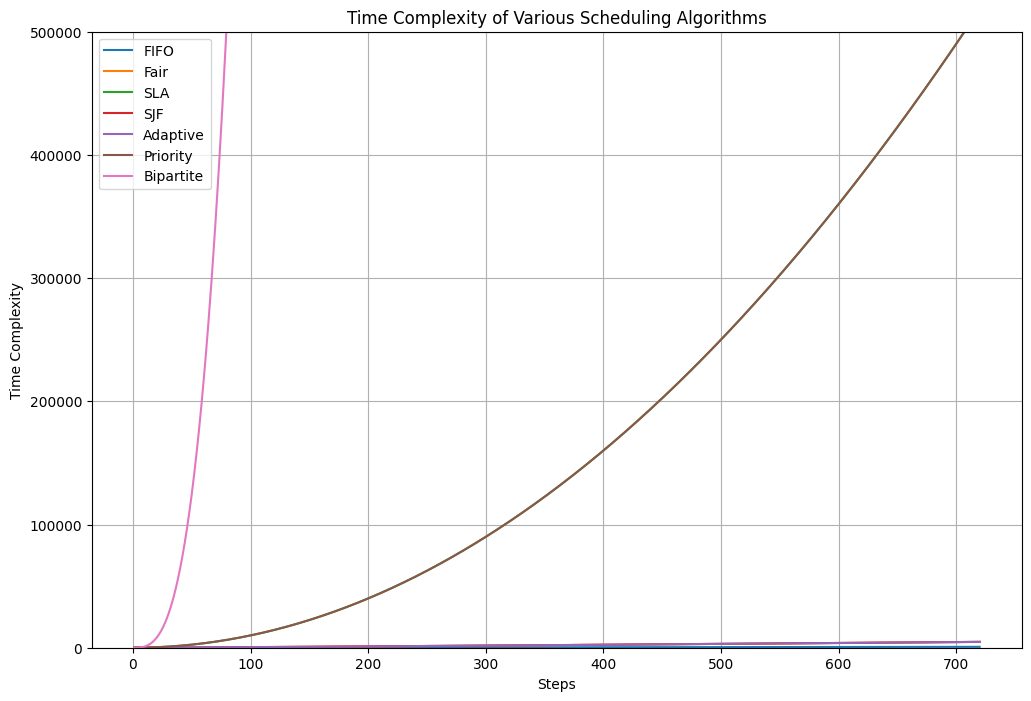

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Time complexity functions for different scheduling algorithms
def fifo(n):
    return n

def fair(n):
    return n * np.log(n)

def sla(n):
    return n**2

def sjf(n):
    return n * np.log(n)  # Simplified assumption

def adaptive(n):
    return n * np.log(n)  # Simplified assumption

def priority(n):
    return n**2

def bipartite(n):
    return n**3

# Number of steps
steps = np.arange(1, 721)

# Compute time complexities
fifo_complexity = fifo(steps)
fair_complexity = fair(steps)
sla_complexity = sla(steps)
sjf_complexity = sjf(steps)
adaptive_complexity = adaptive(steps)
priority_complexity = priority(steps)
bipartite_complexity = bipartite(steps)

# Plotting the time complexities
plt.figure(figsize=(12, 8))
plt.plot(steps, fifo_complexity, label="FIFO")
plt.plot(steps, fair_complexity, label="Fair")
plt.plot(steps, sla_complexity, label="SLA")
plt.plot(steps, sjf_complexity, label="SJF")
plt.plot(steps, adaptive_complexity, label="Adaptive")
plt.plot(steps, priority_complexity, label="Priority")
plt.plot(steps, bipartite_complexity, label="Bipartite")

plt.yscale('linear')
plt.xlabel('Steps')
plt.ylabel('Time Complexity')
plt.title('Time Complexity of Various Scheduling Algorithms')
plt.legend()
plt.grid(True)
plt.ylim(0, 500000)  # Adjusting the y-axis limit to make all lines visible
plt.show()


In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()


Saving tasks_dataset.csv to tasks_dataset.csv


                 Metric        FIFO        Fair
0  Total Execution Time  324.000000  324.000000
1  Resource Utilization    2.950617    2.950617
2      Operational Cost  956.000000  956.000000
3             Idle Time    0.000000    0.000000


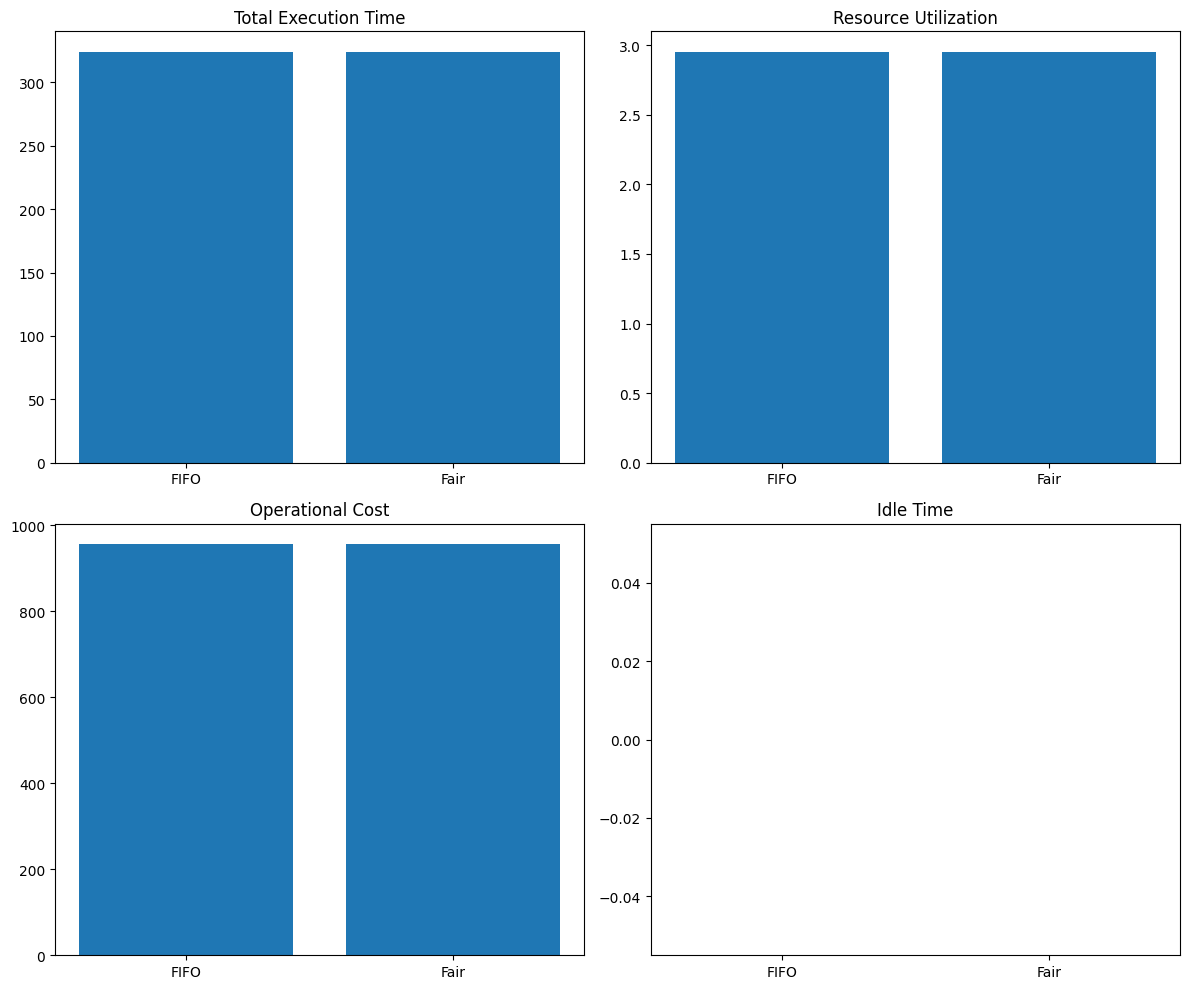

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

# Load the dataset
df = pd.read_csv("/content/tasks_dataset.csv")

# Convert dependencies from string to list of integers, handling NaN values
df['dependencies'] = df['dependencies'].apply(lambda x: list(map(int, x.split(','))) if pd.notna(x) and x else [])

# Define FIFO Scheduler
def fifo_scheduler(tasks):
    sorted_tasks = tasks.sort_values(by='arrival_time')
    schedule = []
    time = 0
    for _, task in sorted_tasks.iterrows():
        start_time = time
        end_time = time + task['duration']
        schedule.append((task['task_id'], start_time, end_time))
        time = end_time
    return schedule

# Define Fair Scheduler (Simple Round-Robin for demonstration)
def fair_scheduler(tasks, quantum=1):
    tasks = tasks.copy()
    tasks['remaining_time'] = tasks['duration']
    time = 0
    schedule = []
    task_queue = deque(tasks.itertuples(index=False))

    while task_queue:
        task = task_queue.popleft()
        if task.remaining_time > quantum:
            start_time = time
            end_time = time + quantum
            schedule.append((task.task_id, start_time, end_time))
            time = end_time
            task_queue.append(task._replace(remaining_time=task.remaining_time - quantum))
        else:
            start_time = time
            end_time = time + task.remaining_time
            schedule.append((task.task_id, start_time, end_time))
            time = end_time

    return schedule

# Calculate Total Execution Time
def calculate_total_execution_time(schedule):
    return schedule[-1][2] if schedule else 0

# Calculate Resource Utilization
def calculate_resource_utilization(schedule, tasks):
    total_time = calculate_total_execution_time(schedule)
    total_resources_used = sum(tasks.set_index('task_id').loc[task_id, 'resource_requirements'] * (end - start) for task_id, start, end in schedule)
    return total_resources_used / total_time if total_time > 0 else 0

# Calculate Operational Cost (Assume cost is proportional to resources and duration)
def calculate_operational_cost(schedule, tasks):
    return sum(tasks.set_index('task_id').loc[task_id, 'resource_requirements'] * (end - start) for task_id, start, end in schedule)

# Calculate Idle Time
def calculate_idle_time(schedule):
    total_time = calculate_total_execution_time(schedule)
    busy_time = sum(end - start for _, start, end in schedule)
    return total_time - busy_time

# Load the dataset
tasks = pd.read_csv("/content/tasks_dataset.csv")
tasks['dependencies'] = tasks['dependencies'].apply(lambda x: list(map(int, x.split(','))) if pd.notna(x) and x else [])

# Run FIFO Scheduler
fifo_schedule = fifo_scheduler(tasks)
fifo_total_execution_time = calculate_total_execution_time(fifo_schedule)
fifo_resource_utilization = calculate_resource_utilization(fifo_schedule, tasks)
fifo_operational_cost = calculate_operational_cost(fifo_schedule, tasks)
fifo_idle_time = calculate_idle_time(fifo_schedule)

# Run Fair Scheduler
fair_schedule = fair_scheduler(tasks)
fair_total_execution_time = calculate_total_execution_time(fair_schedule)
fair_resource_utilization = calculate_resource_utilization(fair_schedule, tasks)
fair_operational_cost = calculate_operational_cost(fair_schedule, tasks)
fair_idle_time = calculate_idle_time(fair_schedule)

# Compare Results
results = {
    'Metric': ['Total Execution Time', 'Resource Utilization', 'Operational Cost', 'Idle Time'],
    'FIFO': [fifo_total_execution_time, fifo_resource_utilization, fifo_operational_cost, fifo_idle_time],
    'Fair': [fair_total_execution_time, fair_resource_utilization, fair_operational_cost, fair_idle_time]
}

results_df = pd.DataFrame(results)
print(results_df)

# Plot the results
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

axs[0, 0].bar(['FIFO', 'Fair'], results_df.loc[results_df['Metric'] == 'Total Execution Time', ['FIFO', 'Fair']].values[0])
axs[0, 0].set_title('Total Execution Time')

axs[0, 1].bar(['FIFO', 'Fair'], results_df.loc[results_df['Metric'] == 'Resource Utilization', ['FIFO', 'Fair']].values[0])
axs[0, 1].set_title('Resource Utilization')

axs[1, 0].bar(['FIFO', 'Fair'], results_df.loc[results_df['Metric'] == 'Operational Cost', ['FIFO', 'Fair']].values[0])
axs[1, 0].set_title('Operational Cost')

axs[1, 1].bar(['FIFO', 'Fair'], results_df.loc[results_df['Metric'] == 'Idle Time', ['FIFO', 'Fair']].values[0])
axs[1, 1].set_title('Idle Time')

plt.tight_layout()
plt.show()


In [ ]:
import csv

class Task:
    def __init__(self, task_id, duration, dependencies, resource_requirements, priority, sla_deadline, arrival_time):
        self.task_id = task_id
        self.duration = int(duration)
        self.dependencies = dependencies.split(',') if dependencies else []
        self.resource_requirements = int(resource_requirements)
        self.priority = int(priority)
        self.sla_deadline = int(sla_deadline)
        self.arrival_time = int(arrival_time)

def read_tasks_from_csv(filename):
    tasks = []
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            task = Task(
                row['task_id'],
                row['duration'],
                row['dependencies'],
                row['resource_requirements'],
                row['priority'],
                row['sla_deadline'],
                row['arrival_time']
            )
            tasks.append(task)
    return tasks

def sjf(tasks):
    tasks.sort(key=lambda x: x.duration)  # Sort tasks by duration (SJF)

    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for task in tasks:
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += current_time + task.duration - task.arrival_time
        current_time += task.duration

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time

def sla(tasks):
    tasks.sort(key=lambda x: x.sla_deadline)  # Sort tasks by SLA deadline

    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for task in tasks:
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += max(current_time + task.duration - task.arrival_time, 0)
        current_time += task.duration
        if current_time > task.sla_deadline:
            # SLA breach penalty
            total_turnaround_time += current_time - task.sla_deadline

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time

# Example usage
if __name__ == "__main__":
    filename = "/content/tasks_dataset.csv"  # Update with your CSV file path
    tasks = read_tasks_from_csv(filename)

    sjf_waiting_time, sjf_turnaround_time = sjf(tasks)
    print("SJF Average Waiting Time:", sjf_waiting_time)
    print("SJF Average Turnaround Time:", sjf_turnaround_time)

    sla_waiting_time, sla_turnaround_time = sla(tasks)
    print("SLA Average Waiting Time:", sla_waiting_time)
    print("SLA Average Turnaround Time:", sla_turnaround_time)


SJF Average Waiting Time: 115.9
SJF Average Turnaround Time: 122.0
SLA Average Waiting Time: 155.04
SLA Average Turnaround Time: 299.54


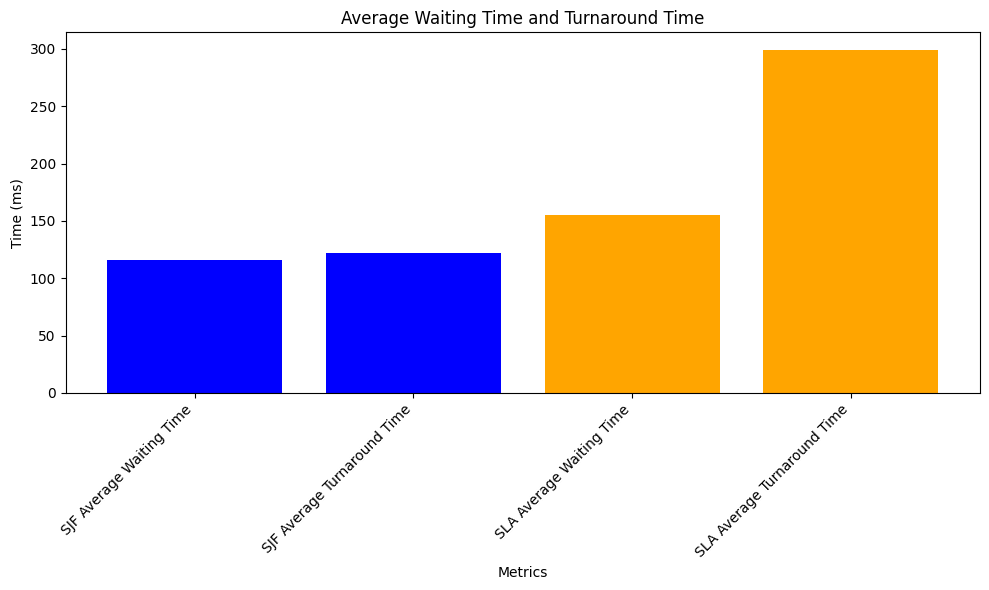

In [ ]:
import matplotlib.pyplot as plt

# Data
sjf_waiting_time = 115.9
sjf_turnaround_time = 122.0
sla_waiting_time = 155.04
sla_turnaround_time = 299.54

# Labels
labels = ['SJF Average Waiting Time', 'SJF Average Turnaround Time', 'SLA Average Waiting Time', 'SLA Average Turnaround Time']

# Values
values = [sjf_waiting_time, sjf_turnaround_time, sla_waiting_time, sla_turnaround_time]

# Create bar graph
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'blue', 'orange', 'orange'])
plt.xlabel('Metrics')
plt.ylabel('Time (ms)')
plt.title('Average Waiting Time and Turnaround Time')
plt.xticks(rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import csv
from collections import defaultdict
import heapq

class Task:
    def __init__(self, task_id, duration, dependencies, resource_requirements, priority, sla_deadline, arrival_time):
        self.task_id = task_id
        self.duration = int(duration)
        self.dependencies = dependencies.split(',') if dependencies else []
        self.resource_requirements = int(resource_requirements)
        self.priority = int(priority)
        self.sla_deadline = int(sla_deadline)
        self.arrival_time = int(arrival_time)

    # Define how to compare two Task objects based on arrival_time
    def __lt__(self, other):
        return self.arrival_time < other.arrival_time

# ... (rest of the code remains the same)

def adaptive(tasks):
    task_queue = []
    for task in tasks:
        heapq.heappush(task_queue, (task.arrival_time, task))

    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    while task_queue:
        _, task = heapq.heappop(task_queue)
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += max(current_time + task.duration - task.arrival_time, 0)
        current_time += task.duration

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time



def priority(tasks):
    tasks.sort(key=lambda x: x.priority, reverse=True)  # Sort tasks by priority

    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for task in tasks:
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += current_time + task.duration - task.arrival_time
        current_time += task.duration

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time

def bipartite_graph(tasks):
    # Construct the bipartite graph
    graph = defaultdict(list)
    for task in tasks:
        for dependency in task.dependencies:
            graph[dependency].append(task.task_id)

    # Topological sorting to determine task execution order
    task_order = []
    visited = set()
    def dfs(node):
        visited.add(node)
        for neighbor in graph[node]:
            if neighbor not in visited:
                dfs(neighbor)
        task_order.append(node)
    # Iterate over a copy of the keys to avoid modifying the dictionary during iteration
    for task_id in list(graph.keys()):
        if task_id not in visited:
            dfs(task_id)

    # Calculate waiting and turnaround time
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    for task_id in reversed(task_order):
        task = next((t for t in tasks if t.task_id == task_id), None)
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += current_time + task.duration - task.arrival_time
        current_time += task.duration

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time

# Example usage
if __name__ == "__main__":
    filename = '/content/tasks_dataset.csv'  # Update with your CSV file name
    tasks = read_tasks_from_csv(filename)

    adaptive_waiting_time, adaptive_turnaround_time = adaptive(tasks)
    print("Adaptive Average Waiting Time:", adaptive_waiting_time)
    print("Adaptive Average Turnaround Time:", adaptive_turnaround_time)

    priority_waiting_time, priority_turnaround_time = priority(tasks)
    print("Priority Average Waiting Time:", priority_waiting_time)
    print("Priority Average Turnaround Time:", priority_turnaround_time)

    bipartite_waiting_time, bipartite_turnaround_time = bipartite_graph(tasks)
    print("Bipartite Graph Average Waiting Time:", bipartite_waiting_time)
    print("Bipartite Graph Average Turnaround Time:", bipartite_turnaround_time)

# Example usage
if __name__ == "__main__":
    filename = '/content/tasks_dataset.csv'  # Update with your CSV file name
    tasks = read_tasks_from_csv(filename)

    adaptive_waiting_time, adaptive_turnaround_time = adaptive(tasks)
    print("Adaptive Average Waiting Time:", adaptive_waiting_time)
    print("Adaptive Average Turnaround Time:", adaptive_turnaround_time)

    priority_waiting_time, priority_turnaround_time = priority(tasks)
    print("Priority Average Waiting Time:", priority_waiting_time)
    print("Priority Average Turnaround Time:", priority_turnaround_time)

    bipartite_waiting_time, bipartite_turnaround_time = bipartite_graph(tasks)
    print("Bipartite Graph Average Waiting Time:", bipartite_waiting_time)
    print("Bipartite Graph Average Turnaround Time:", bipartite_turnaround_time)


Adaptive Average Waiting Time: 141.54
Adaptive Average Turnaround Time: 148.02
Priority Average Waiting Time: 138.56
Priority Average Turnaround Time: 144.78
Bipartite Graph Average Waiting Time: 137.8
Bipartite Graph Average Turnaround Time: 143.42
Adaptive Average Waiting Time: 141.54
Adaptive Average Turnaround Time: 148.02
Priority Average Waiting Time: 138.56
Priority Average Turnaround Time: 144.78
Bipartite Graph Average Waiting Time: 137.8
Bipartite Graph Average Turnaround Time: 143.42


In [ ]:
import csv

class Task:
    def __init__(self, task_id, duration, dependencies, resource_requirements, priority, sla_deadline, arrival_time):
        self.task_id = task_id
        self.duration = int(duration)
        self.dependencies = dependencies.split(',') if dependencies else []
        self.resource_requirements = int(resource_requirements)
        self.priority = int(priority)
        self.sla_deadline = int(sla_deadline)
        self.arrival_time = int(arrival_time)

def read_tasks_from_csv(filename):
    tasks = []
    with open(filename, 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            task = Task(
                row['task_id'],
                row['duration'],
                row['dependencies'],
                row['resource_requirements'],
                row['priority'],
                row['sla_deadline'],
                row['arrival_time']
            )
            tasks.append(task)
    return tasks

def fifo(tasks):
    tasks.sort(key=lambda x: x.arrival_time)  # Sort tasks by arrival time (FIFO)

    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for task in tasks:
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += current_time + task.duration - task.arrival_time
        current_time += task.duration

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time

def fair(tasks):
    tasks.sort(key=lambda x: (x.arrival_time, x.duration))  # Sort tasks by arrival time then by duration (Fair)

    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0

    for task in tasks:
        total_waiting_time += max(current_time - task.arrival_time, 0)
        total_turnaround_time += current_time + task.duration - task.arrival_time
        current_time += task.duration

    avg_waiting_time = total_waiting_time / len(tasks)
    avg_turnaround_time = total_turnaround_time / len(tasks)

    return avg_waiting_time, avg_turnaround_time

# Example usage
if __name__ == "__main__":
    filename = '/content/tasks_dataset.csv'  # Update with your CSV file name
    tasks = read_tasks_from_csv(filename)

    fifo_waiting_time, fifo_turnaround_time = fifo(tasks)
    print("FIFO Average Waiting Time:", fifo_waiting_time)
    print("FIFO Average Turnaround Time:", fifo_turnaround_time)

    fair_waiting_time, fair_turnaround_time = fair(tasks)
    print("Fair Average Waiting Time:", fair_waiting_time)
    print("Fair Average Turnaround Time:", fair_turnaround_time)


FIFO Average Waiting Time: 140.5
FIFO Average Turnaround Time: 146.98
Fair Average Waiting Time: 139.1
Fair Average Turnaround Time: 145.58


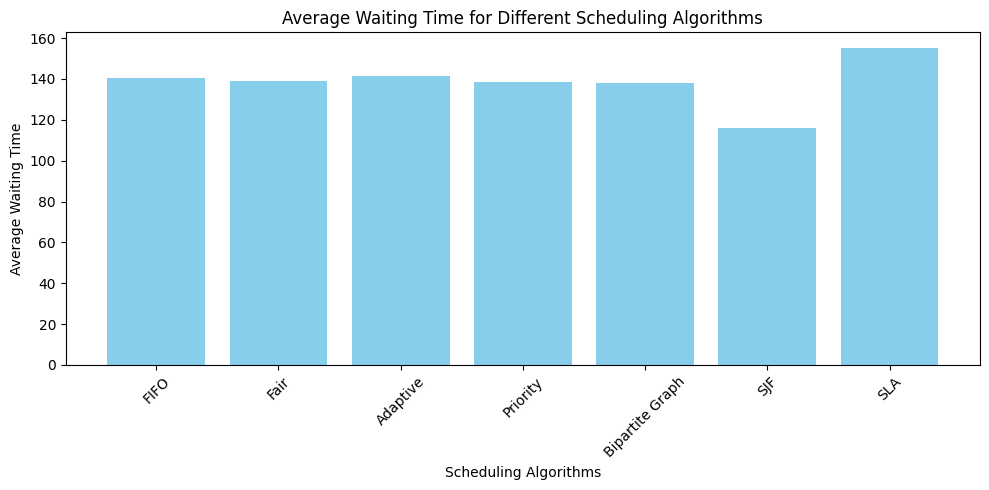

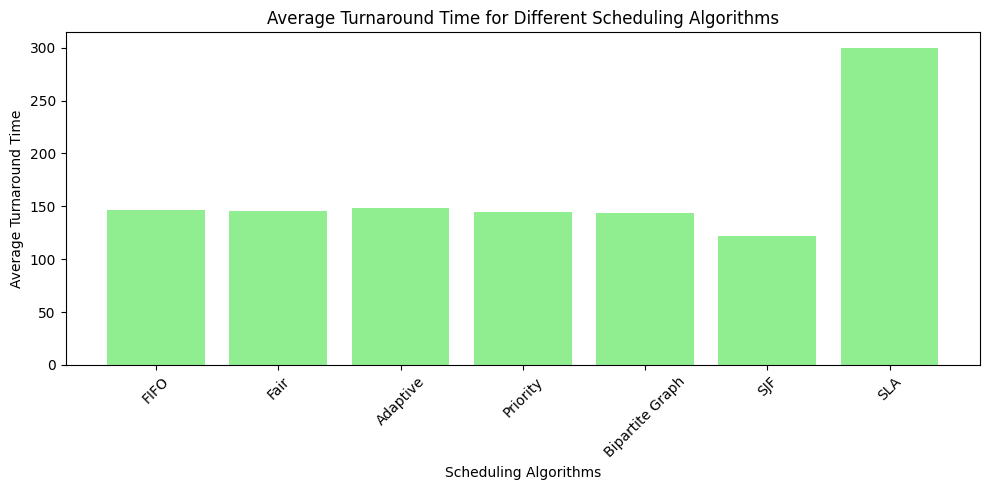

In [ ]:
import matplotlib.pyplot as plt

# Data
algorithms = ['FIFO', 'Fair', 'Adaptive', 'Priority', 'Bipartite Graph', 'SJF', 'SLA']
waiting_times = [140.5, 139.1, 141.54, 138.56, 137.8, 115.9, 155.04]
turnaround_times = [146.98, 145.58, 148.02, 144.78, 143.42, 122.0, 299.54]

# Plotting waiting time
plt.figure(figsize=(10, 5))
plt.bar(algorithms, waiting_times, color='skyblue')
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting turnaround time
plt.figure(figsize=(10, 5))
plt.bar(algorithms, turnaround_times, color='lightgreen')
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Turnaround Time')
plt.title('Average Turnaround Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


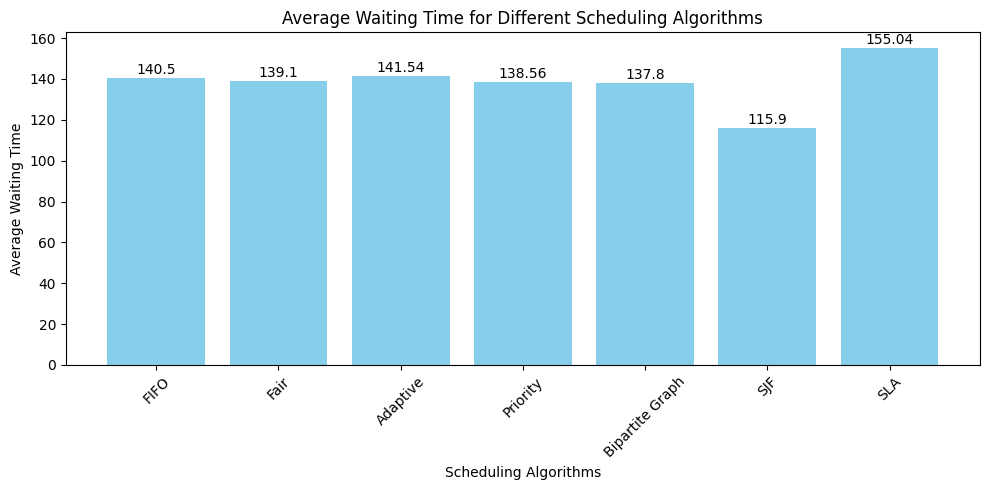

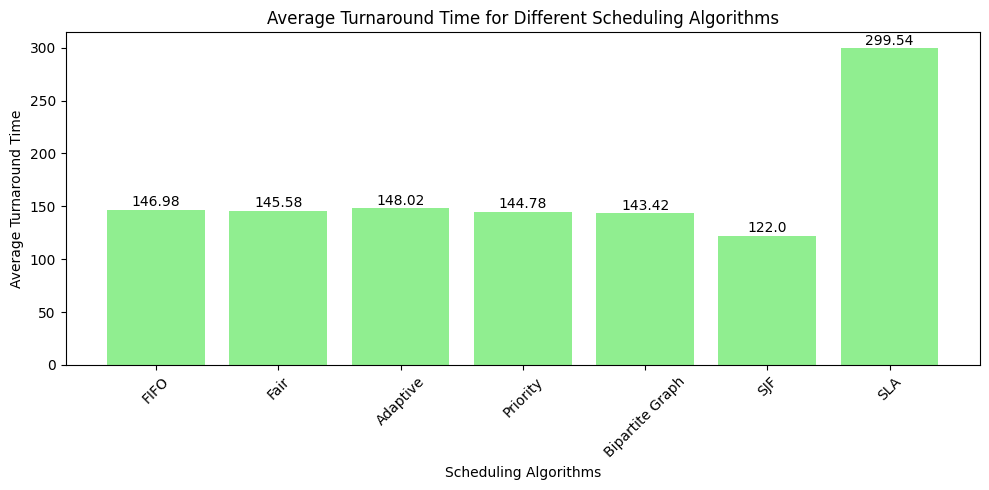

In [ ]:
import matplotlib.pyplot as plt

# Data
algorithms = ['FIFO', 'Fair', 'Adaptive', 'Priority', 'Bipartite Graph', 'SJF', 'SLA']
waiting_times = [140.5, 139.1, 141.54, 138.56, 137.8, 115.9, 155.04]
turnaround_times = [146.98, 145.58, 148.02, 144.78, 143.42, 122.0, 299.54]

bar_width = 0.4

# Plotting waiting time
plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, waiting_times, color='skyblue')
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Waiting Time')
plt.title('Average Waiting Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)

# Adding values on top of the bars
for bar, value in zip(bars, waiting_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting turnaround time
plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, turnaround_times, color='lightgreen')
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Turnaround Time')
plt.title('Average Turnaround Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)

# Adding values on top of the bars
for bar, value in zip(bars, turnaround_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


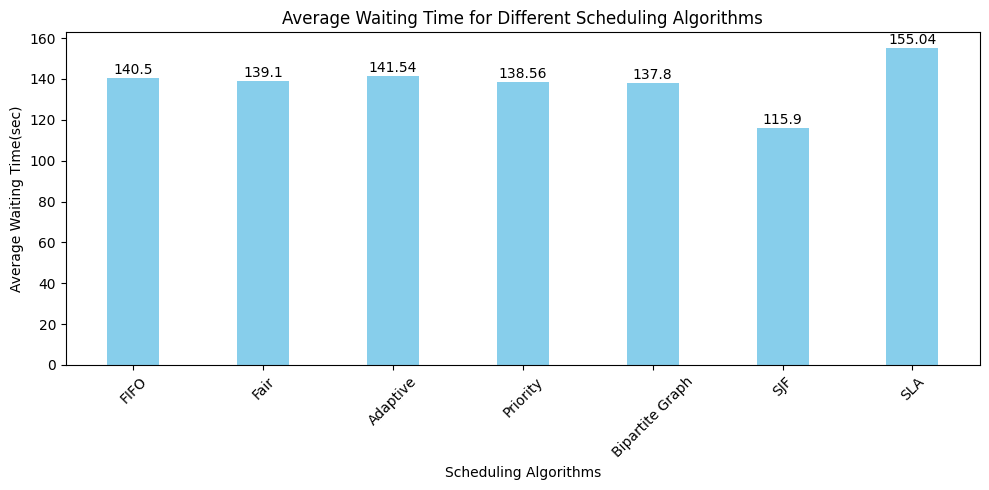

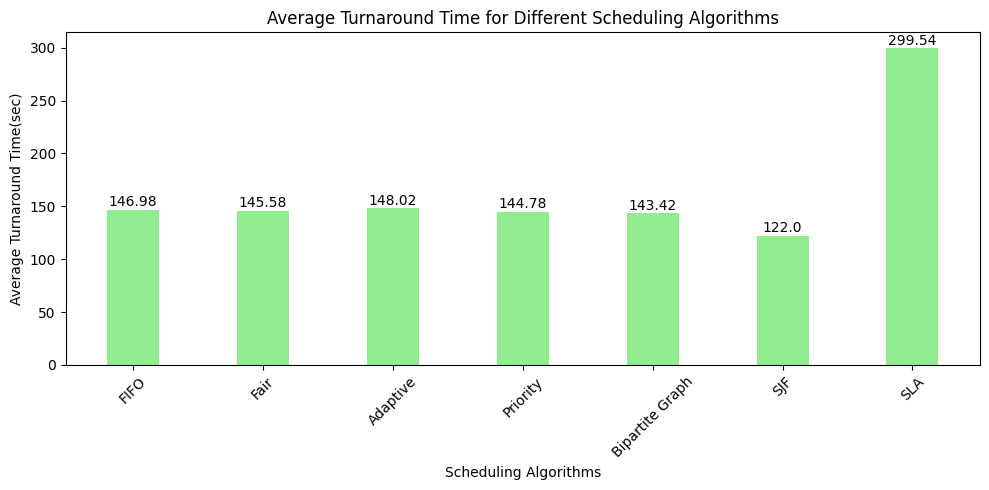

In [ ]:
import matplotlib.pyplot as plt

# Data
algorithms = ['FIFO', 'Fair', 'Adaptive', 'Priority', 'Bipartite Graph', 'SJF', 'SLA']
waiting_times = [140.5, 139.1, 141.54, 138.56, 137.8, 115.9, 155.04]
turnaround_times = [146.98, 145.58, 148.02, 144.78, 143.42, 122.0, 299.54]

# Bar width
bar_width = 0.4

# Plotting waiting time
plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, waiting_times, color='skyblue', width=bar_width)
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Waiting Time(sec)')
plt.title('Average Waiting Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)

# Adding values on top of the bars
for bar, value in zip(bars, waiting_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting turnaround time
plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, turnaround_times, color='lightgreen', width=bar_width)
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Turnaround Time(sec)')
plt.title('Average Turnaround Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)

# Adding values on top of the bars
for bar, value in zip(bars, turnaround_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


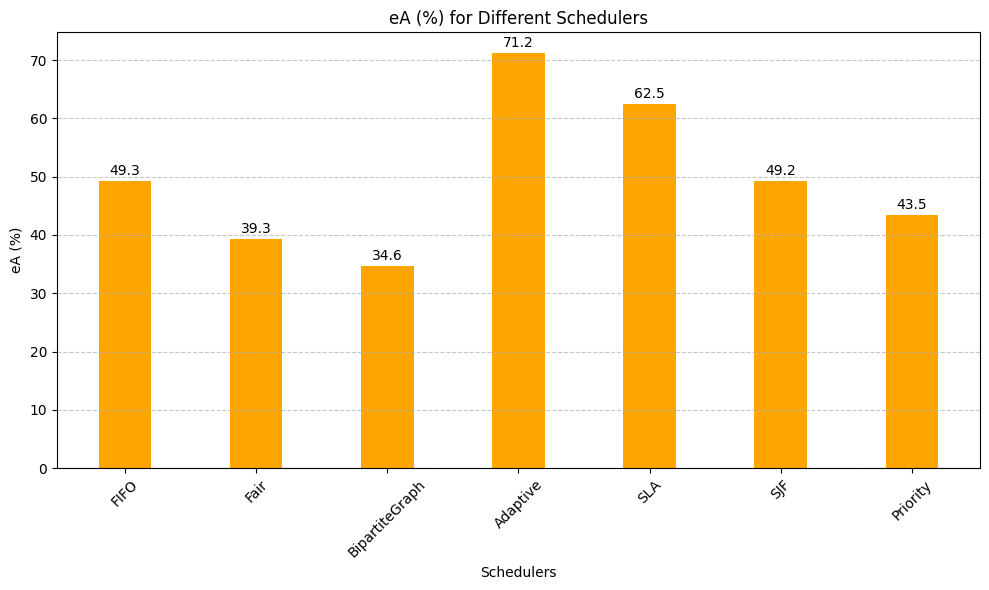

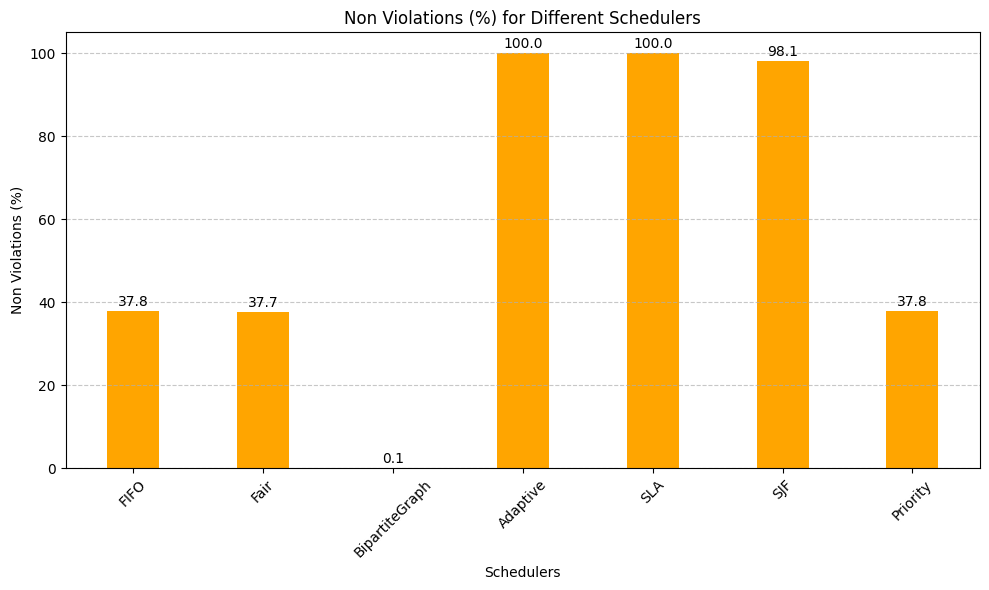

In [ ]:
import matplotlib.pyplot as plt

# Data
schedulers = ['FIFO', 'Fair', 'BipartiteGraph', 'Adaptive', 'SLA', 'SJF', 'Priority']
eA = [49.3, 39.3, 34.6, 71.2, 62.5, 49.2, 43.5]
non_violations = [37.8, 37.7, 0.1, 100.0, 100.0, 98.1, 37.8]

# Function to create and show bar plots
def create_bar_plot(parameter_name, values):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(schedulers, values, color='orange', width=0.4)
    plt.xlabel('Schedulers')
    plt.ylabel(parameter_name)
    plt.title(f'{parameter_name} for Different Schedulers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding values on top of the bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Create bar plots for each parameter
create_bar_plot('eA (%)', eA)
create_bar_plot('Non Violations (%)', non_violations)


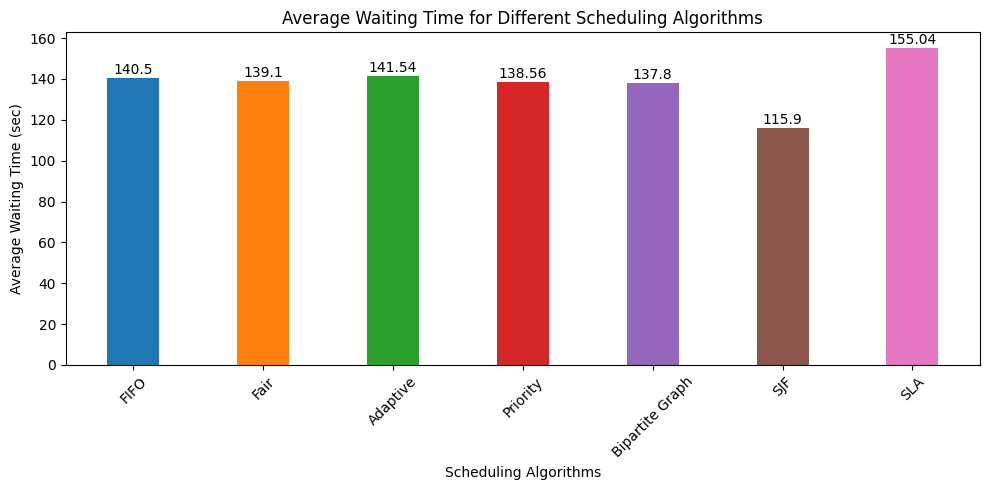

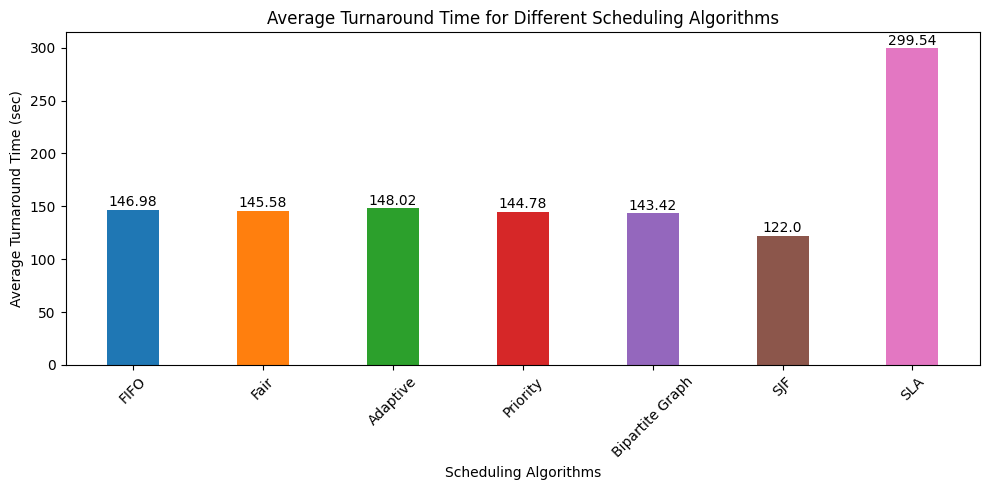

In [ ]:
import matplotlib.pyplot as plt

# Data
algorithms = ['FIFO', 'Fair', 'Adaptive', 'Priority', 'Bipartite Graph', 'SJF', 'SLA']
waiting_times = [140.5, 139.1, 141.54, 138.56, 137.8, 115.9, 155.04]
turnaround_times = [146.98, 145.58, 148.02, 144.78, 143.42, 122.0, 299.54]

# Bar width
bar_width = 0.4

# Colors for each scheduler
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Plotting waiting time
plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, waiting_times, color=colors, width=bar_width)
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Waiting Time (sec)')
plt.title('Average Waiting Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)

# Adding values on top of the bars
for bar, value in zip(bars, waiting_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Plotting turnaround time
plt.figure(figsize=(10, 5))
bars = plt.bar(algorithms, turnaround_times, color=colors, width=bar_width)
plt.xlabel('Scheduling Algorithms')
plt.ylabel('Average Turnaround Time (sec)')
plt.title('Average Turnaround Time for Different Scheduling Algorithms')
plt.xticks(rotation=45)

# Adding values on top of the bars
for bar, value in zip(bars, turnaround_times):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()


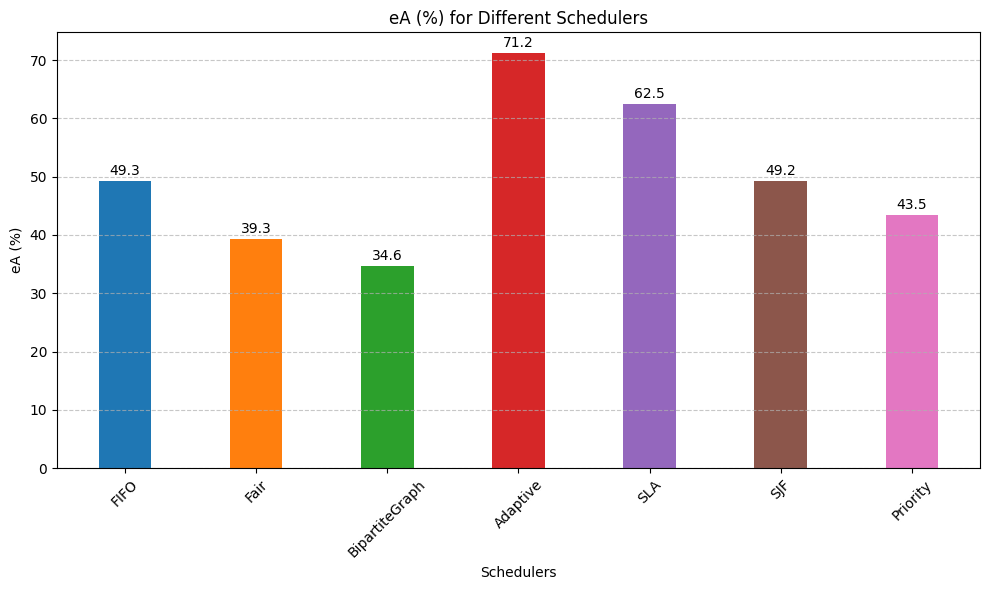

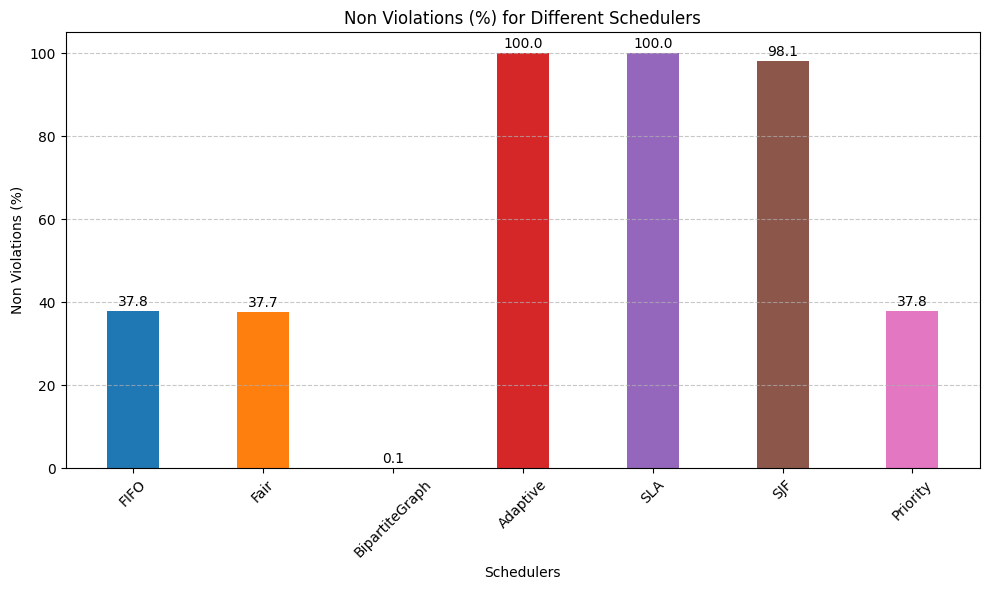

In [ ]:
import matplotlib.pyplot as plt

# Data
schedulers = ['FIFO', 'Fair', 'BipartiteGraph', 'Adaptive', 'SLA', 'SJF', 'Priority']
eA = [49.3, 39.3, 34.6, 71.2, 62.5, 49.2, 43.5]
non_violations = [37.8, 37.7, 0.1, 100.0, 100.0, 98.1, 37.8]

# Colors for each scheduler
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Function to create and show bar plots
def create_bar_plot(parameter_name, values, colors):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(schedulers, values, color=colors, width=0.4)
    plt.xlabel('Schedulers')
    plt.ylabel(parameter_name)
    plt.title(f'{parameter_name} for Different Schedulers')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Adding values on top of the bars
    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

# Create bar plots for each parameter
create_bar_plot('eA (%)', eA, colors)
create_bar_plot('Non Violations (%)', non_violations, colors)
